2024.06.28 @author: Shiho Mukaida

In [1]:
import matplotlib.figure as figure
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import numpy.matlib
import pandas as pd
from sklearn.model_selection import KFold
from sklearn import model_selection, metrics, svm
from sklearn.linear_model import Ridge, LassoCV, ElasticNetCV, ElasticNet
from sklearn import linear_model
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import gaussian_process as gp
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, Matern, DotProduct
from sklearn.model_selection import LeaveOneOut
from sklearn.inspection import permutation_importance
import seaborn as sns
import sklearn, optuna, glob, pickle, warnings, os, datetime, time, math
import shap
#warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
now = datetime.datetime.now()

In [2]:
# 日本語フォントのパスを指定（システムにインストールされているフォントを使用）
font_path = '/root/Fonts/arial.ttf' # Linuxの場合
#font_path = 'C:/Windows/Fonts/msgothic.ttc'  # Windows の場合
# font_path = '/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc'  # macOS の場合

# フォントプロパティを設定
font_prop = fm.FontProperties(fname=font_path)

# rcParamsでデフォルトのフォントを設定
plt.rcParams['font.family'] = font_prop.get_name()

In [3]:
print("pandas: " + pd.__version__)
print("numpy: " + np.__version__)
print("sklearn: " + sklearn.__version__)
print("xgboost: " + xgb.__version__)
print("optuna: " + optuna.__version__)

pandas: 2.2.2
numpy: 2.0.1
sklearn: 1.5.1
xgboost: 2.1.0
optuna: 3.6.1


In [4]:
# Measure time
starttime = time.time()

In [5]:
DoDoubleCV = 0; # Please change to "0" if you do not want to do double cross-validation
CalPermutationimportance = 1 # Please change to "0" if you do not want to calculate permutation importance
ShowYYplots = 1; # Please change to "0" if you do not want to show plots of actural Y and estimated Y
ShowCorrelation = 1 # Please change to "0" if you do not want to show correlation graph
ShowPairplots = 1 # Please change to "0" if you do not want to show pair plots of each variable

loo = LeaveOneOut()
#FoldNumber = 20 # Number of fold in cross-validation
FoldNumber = loo # leave-one-out cross-validation

# Number of trials for optuna
trials_number = 100

# Number of top-ranked variables of permuation importance
sel_num = 20

In [6]:
if FoldNumber == loo:
    Fold_param = loo
    Fold_cv = loo
else:
    Fold_param = KFold(n_splits=FoldNumber,shuffle=True) #パラメータ設定用Random seedは毎回変わる
    SEED = 10000
    Fold_cv = KFold(n_splits=FoldNumber,shuffle=True, random_state=SEED) #検証用

In [7]:
# Load data set
datapd = pd.read_csv("reduced_1023.csv", encoding='cp932', index_col=0)
ycolumn = 0
targetname = datapd.columns[ycolumn]

FileNotFoundError: [Errno 2] No such file or directory: 'reduced_1023.csv'

In [ ]:
print(targetname)

Bulk modulus


In [ ]:
datapd = datapd.dropna(subset=[targetname]) # 目的変数のカラムのNaNがある行を削除
datapd = datapd.drop_duplicates() # 重複削除

In [ ]:
actualy = datapd.iloc[:,ycolumn]
actualy = pd.DataFrame(actualy, index = datapd.index)
actualy2 = actualy.copy()
actualy2 = actualy2.rename(columns={targetname : 'ActualY'})
data = np.array(datapd)
data = data.astype(float)
Originaly = np.ravel( np.c_[data[:,ycolumn]] )
OriginalX = data[:,1:]
datapd = datapd.iloc[:,1:] # Only X

# 予測用サンプルがない時
data_predictionpd = datapd
# 予測用サンプルがある時（）
#data_predictionpd = pd.read_csv("randomsampling.csv", encoding='cp932', index_col=0)
#data_predictionpd = data_predictionpd[datapd.columns]

OriginalX_prediction = np.array(data_predictionpd)
OriginalX_prediction = OriginalX_prediction.astype(float)

In [ ]:
datapd.head() # Xが合っているか確認

,Domain size,Stacking number,1/d,1/t,Nitrogen content,Edge site amount,Sbasal,Pore size,Surface tortuosity,S
sample,,,,,,,,,,
SWCNT,64.8,1.0,0.285714,1.0,0,633,1144,3.5,1.0,1176
MWCNT,26.6,36.8,0.066667,1.0,0,1540,72,15.0,1.0,76
Y-PFA-Pr7(2)-H9(3),3.3,1.0,0.769231,1.0,0,12534,2719,1.3,1.0,3345
Y-Ac6(4)-H9(3),2.2,1.5,0.769231,1.0,0,18645,1783,1.3,1.0,2715
X-Ac6(4)-H8.5(3),1.7,1.6,0.769231,1.0,0,23575,1657,1.3,1.0,2835


In [ ]:
# delete variables with zero variance
def variableszerovariance( X ):
    Var0Variable = np.where( X.var(axis=0) == 0 )
    if len(Var0Variable[0]) == 0:
        print( "No variables with zero variance" )
    else:
        print( "{0} variable(s) with zero variance".format(len(Var0Variable[0])))
        print( "Variable number: {0}".format(Var0Variable[0]+1) )
        print( "The variable(s) is(are) deleted." )
    return Var0Variable

Var0Variable = variableszerovariance(OriginalX)
if len(Var0Variable[0]) != 0:
    OriginalX = np.delete(OriginalX, Var0Variable, 1)
    OriginalX_prediction = np.delete(OriginalX_prediction, Var0Variable, 1)
    datapd = datapd.drop(datapd.columns[Var0Variable], axis=1)

No variables with zero variance


In [ ]:
# save csv file excluding explanatory variables with 0 variance
datapd_var0 = pd.concat([actualy, datapd], axis=1)
datapd_var0.to_csv("{0:%Y%m%d}_LeaveVariable0Train.csv".format(now), encoding='cp932')

In [ ]:
# save correlation matrix
visdata = pd.concat([actualy, datapd], axis=1)
visdata.corr().to_csv('{0:%Y%m%d}_Correlation.csv'.format(now), encoding='cp932')

In [ ]:
# Autoscale objective variable (Y) and explanatory variable (X)
X = (OriginalX - OriginalX.mean(axis=0)) / OriginalX.std(axis=0, ddof=1)
y = (Originaly - Originaly.mean(axis=0)) / Originaly.std(axis=0, ddof=1)
X_prediction = (OriginalX_prediction - OriginalX.mean(axis=0)) / OriginalX.std(axis=0, ddof=1)

In [ ]:
if DoDoubleCV != 0:
    # double cross-validation
    FoldNumberDcvin = 20 # Number of fold in "inner" double cross-validation
    FoldNumberDcvin = KFold(n_splits=FoldNumberDcvin,shuffle=True) # if not FoldNumberDcvin means leave-one-out cross validation, use this
    #FoldNumberDcvout = 5 # Number of fold in "outer" double cross-validation
    FoldNumberDcvout = X.shape[0] # Number of fold in "outer" double cross-validation (leave-one-out)    
    
    Nmin = math.floor( X.shape[0] / FoldNumberDcvout )
    Nmod = X.shape[0] - Nmin * FoldNumberDcvout
    Ind = numpy.matlib.repmat( np.arange( 1, FoldNumberDcvout+1, 1 ), 1, Nmin).ravel()
    if Nmod != 0:
        Ind = np.r_[ Ind, np.arange( 1, Nmod+1, 1 )]
    np.random.seed(10000)
    FoldIndOut = np.random.permutation(Ind)
    np.random.seed()

In [ ]:
RegressionMethodNames = ["PLS","LASSO","RR","EN","LSVR","BR","NLSVR","KR","RF","XGB","GP"]
PredictedRegressionMethodNames = ["PLS","LASSO","RR","EN","LSVR","BR","Std. of BR predicted values","NLSVR","KR","RF","XGB","GP","Std. of GP predicted values"]
ScoreNames = ["PLS","LASSO","RR", "EN", "LSVR", "BR", "RF", "XGB"]
StatisticsNames = ["r2","MAE","r2cv","MAEcv", "r2Dcv", "MAEDcv"]
NumberOfRegressionMethods = len(RegressionMethodNames); # Number of regression methods
ScoreAll = np.zeros( (len(ScoreNames), X.shape[1]) )

In [ ]:
# Calculated and predicted Y
CalculatedYAll = np.zeros( (X.shape[0], NumberOfRegressionMethods) )
EstimatedYcvAll = np.zeros( (X.shape[0], NumberOfRegressionMethods) )
PredictedYAll = np.zeros( (X_prediction.shape[0], NumberOfRegressionMethods + 2) )
EstimatedYDcvAll = np.zeros( (X.shape[0], NumberOfRegressionMethods) )
Permutationimportance = np.zeros((len(RegressionMethodNames), X.shape[1]))

In [ ]:
def score_model(calculatedy, estimatedy, model_name):
    ScoreModel = np.zeros((2, 2))
    # 決定係数
    rr = metrics.r2_score(Originaly, calculatedy)
    rr2 = metrics.r2_score(Originaly, estimatedy)
    # Mean Absolute Error 平均絶対誤差
    mae = np.average(abs(Originaly-calculatedy))
    mae2 = np.average(abs(Originaly-estimatedy))
    ScoreModel[0,:]=np.c_[rr, mae]
    ScoreModel[1,:]=np.c_[rr2, mae2]
    ScoreModel = pd.DataFrame(ScoreModel)
    ScoreModel.columns = ["r2", "mae"]
    ScoreModel.index = ["calculated", "estimatedcv"]
    ScoreModel.to_csv( "{0:%Y%m%d}_{1}_score.csv".format(now, model_name), encoding='cp932')
    display(ScoreModel)

### 1. Partial Least Squares (PLS)

In [ ]:
max_pls_component_number = 50

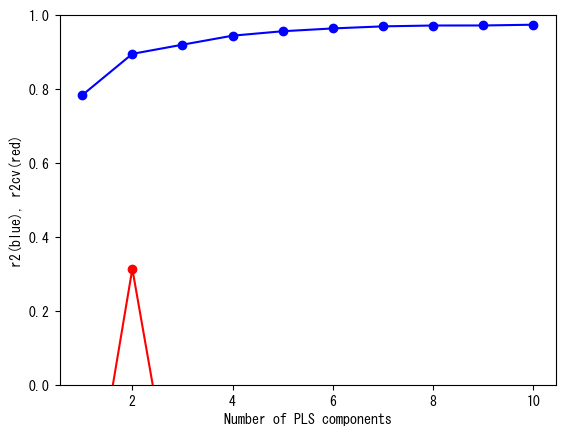

In [ ]:
pls_components = np.arange(1, min(np.linalg.matrix_rank(X) + 1, max_pls_component_number + 1), 1)
r2all = list()
r2cvall = list()
for pls_component in pls_components:
    pls_model_in_cv = PLSRegression(n_components=pls_component)
    pls_model_in_cv.fit(X, y)
    calculated_y_in_cv = np.ndarray.flatten(pls_model_in_cv.predict(X))
    estimated_y_in_cv = np.ndarray.flatten(model_selection.cross_val_predict(pls_model_in_cv, X, y, cv=Fold_param))
    calculated_y_in_cv = calculated_y_in_cv * y.std(ddof=1) + y.mean()
    estimated_y_in_cv = estimated_y_in_cv * y.std(ddof=1) + y.mean()
    r2all.append(float(1 - sum((y - calculated_y_in_cv) ** 2) / sum((y - y.mean()) ** 2)))
    r2cvall.append(float(1 - sum((y - estimated_y_in_cv) ** 2) / sum((y - y.mean()) ** 2)))
plt.plot(pls_components, r2all, 'bo-')
plt.plot(pls_components, r2cvall, 'ro-')
plt.ylim(0, 1)
plt.xlabel('Number of PLS components')
plt.ylabel('r2(blue), r2cv(red)')
plt.show()

In [ ]:
# Decide the optimal number of components with the minimum R2 value
# 最適成分数におけるPLSモデルの作成
optimal_pls_component_number = np.where(r2cvall == np.max(r2cvall))
optimal_pls_component_number = optimal_pls_component_number[0][0] + 1

In [ ]:
with open('{0:%Y%m%d}_PLS_Optimized_hyperparameter_value.txt'.format(now), 'w') as f_pls:
    print("optimal pls component number: {}".format(optimal_pls_component_number), file=f_pls)

In [ ]:
# Construct PLS model with the optimal number of components and get standard regression coefficient
PLSResult = PLSRegression(n_components=optimal_pls_component_number)
PLSResult.fit(X, y)

PLSRegression(n_components=np.int64(2))

In [ ]:
# Save model
with open('{0:%Y%m%d}_PLS.pickle'.format(now), mode='wb') as fp_pls:
    pickle.dump(PLSResult, fp_pls)

ScoreAll[0,:] = PLSResult.coef_

In [ ]:
# Calculate determinant coefficient and MAE between actual Y and calculated Y (r2 and MAE) and
# determinant coefficient and MAE between actual Y and estimated Y (r2CV and MAECV)
CalculatedYAll[:,0] = PLSResult.predict(X).T*Originaly.std(axis=0, ddof=1) + Originaly.mean(axis=0)
EstimatedYcvAll[:,0] = model_selection.cross_val_predict(PLSResult, X, y, cv=Fold_cv).T*Originaly.std(axis=0, ddof=1) + Originaly.mean(axis=0)
# Prediction(標準化を解除、picklefileを読み込む)
PredictedYAll[:,0] = PLSResult.predict(X_prediction).T*Originaly.std(axis=0, ddof=1) + Originaly.mean(axis=0)

In [ ]:
score_model(CalculatedYAll[:,0], EstimatedYcvAll[:,0], RegressionMethodNames[0])

,r2,mae
calculated,0.895217,0.168213
estimatedcv,0.313591,0.369294


### 2. LASSO

In [ ]:
CandidatesOfLASSOLambda = np.arange(0.01, 0.71, 0.01, dtype=float) # Candidates of L1 weight
# Estimate objective variable (Y) with cross-validation (CV) for each lambda candidate
# Calculate Root-Mean-Squared Error (RMSE) between actual Y and estimated Y with CV for each lambda candidate
# Decide the optimal lambda with the minimum RMSE value
LASSOResult = LassoCV(cv=Fold_param, alphas=CandidatesOfLASSOLambda)

In [ ]:
LASSOResult.fit(X, y)

LassoCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 ]),
        cv=LeaveOneOut())

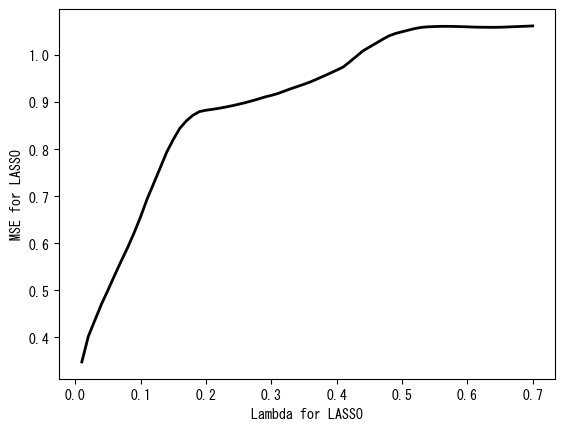

In [ ]:
plt.figure()
plt.plot(LASSOResult.alphas_, LASSOResult.mse_path_.mean(axis=-1), 'k', linewidth=2)
plt.xlabel("Lambda for LASSO")
plt.ylabel("MSE for LASSO")
plt.show()
OptimalLASSOLambda = LASSOResult.alpha_

In [ ]:
with open('{0:%Y%m%d}_LASSO_Optimized_hyperparameter_value.txt'.format(now), 'w') as f_lasso:
    print("Optimal LASSO Lambda: {}".format(OptimalLASSOLambda), file=f_lasso)

In [ ]:
with open('{0:%Y%m%d}_LASSO.pickle'.format(now), mode='wb') as fp_lasso:
    pickle.dump(LASSOResult, fp_lasso)

In [ ]:
ScoreAll[1,:] = LASSOResult.coef_
CalculatedYAll[:,1] = LASSOResult.predict(X).T*Originaly.std(ddof=1) + Originaly.mean()
EstimatedYcvAll[:,1] = model_selection.cross_val_predict(LASSOResult, X, y, cv=Fold_cv).T*Originaly.std(ddof=1) + Originaly.mean()
# Prediction
PredictedYAll[:,1] = LASSOResult.predict(X_prediction).T*Originaly.std(ddof=1) + Originaly.mean()

In [ ]:
score_model(CalculatedYAll[:,1], EstimatedYcvAll[:,1], RegressionMethodNames[1])

,r2,mae
calculated,0.968319,0.078221
estimatedcv,0.631547,0.254877


### 3. Ridge Regression (RR)

In [ ]:
CandidatesOfRidgeLambdas = 2**np.arange( -5, 10, dtype=float) # Candidates of L2 weight
# Estimate objective variable (Y) with cross-validation (CV) for each lambda candidate
# Calculate Root-Mean-Squared Error (RMSE) between actual Y and estimated Y with CV for each lambda candidate
# Decide the optimal lambda with the minimum RMSE value
RMSECvAll = list()
for CandidateOfRidgeLambdas in CandidatesOfRidgeLambdas:
    RRResult = Ridge(alpha=CandidateOfRidgeLambdas)
    PredictedYcv = model_selection.cross_val_predict(RRResult, X, y, cv=Fold_param)*Originaly.std(ddof=1) + Originaly.mean()
    RMSECvAll.append(math.sqrt( sum( (Originaly-PredictedYcv)**2 )/ OriginalX.shape[0]))

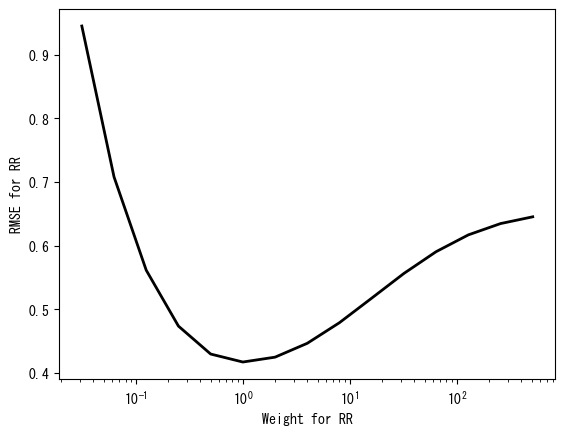

In [ ]:
plt.figure()
plt.plot(CandidatesOfRidgeLambdas, RMSECvAll, 'k', linewidth=2)
plt.xscale("log")
plt.xlabel("Weight for RR")
plt.ylabel("RMSE for RR")
plt.show()

In [ ]:
OptimalRRLambda = CandidatesOfRidgeLambdas[np.where( RMSECvAll == np.min(RMSECvAll) )[0][0]]

In [ ]:
with open('{0:%Y%m%d}_RR_Optimized_hyperparameter_value.txt'.format(now), 'w') as f_rr:
    print("Optimal RR Lambda: {}".format(OptimalRRLambda), file=f_rr)

In [ ]:
RRResult = Ridge(alpha=OptimalRRLambda)
RRResult.fit(X, y)

Ridge(alpha=np.float64(1.0))

In [ ]:
# Save model
with open('{0:%Y%m%d}_RR.pickle'.format(now), mode='wb') as fp_rr:
    pickle.dump(RRResult, fp_rr)

In [ ]:
ScoreAll[2,:] = RRResult.coef_
CalculatedYAll[:,2] = RRResult.predict(X).T*Originaly.std(ddof=1) + Originaly.mean()
EstimatedYcvAll[:,2] = model_selection.cross_val_predict(RRResult, X, y, cv=Fold_cv).T*Originaly.std(ddof=1) + Originaly.mean()
# Prediction
PredictedYAll[:,2] = RRResult.predict(X_prediction).T*Originaly.std(ddof=1) + Originaly.mean()

In [ ]:
score_model(CalculatedYAll[:,2], EstimatedYcvAll[:,2], RegressionMethodNames[2])

,r2,mae
calculated,0.958536,0.094776
estimatedcv,0.548570,0.278246


### 4. Elastic Net (EN)

In [ ]:
CandidatesOfENLambda = np.arange(0.01, 0.71, 0.01, dtype=float) # Candidates of lambda
CandidatesOfENAlpha = np.arange(0.01, 1.00, 0.01, dtype=float) # Candidates of alpha

In [ ]:
# Estimate objective variable (Y) with cross-validation (CV) for each lambda candidate and eachalpha candidate
# Calculate Root-Mean-Squared Error (RMSE) between actual Y and estimated Y with CV for each lambda candidate and eachalpha candidate
# Decide the optimal lambda with the minimum RMSE value
ENResult = ElasticNetCV(cv=Fold_param, l1_ratio=CandidatesOfENAlpha, alphas=CandidatesOfENLambda)
ENResult.fit(X, y)

ElasticNetCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66...
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]))

In [ ]:
np.random.seed()
OptimalAlphaNumberEN = np.where( CandidatesOfENAlpha == ENResult.l1_ratio_ )
OptimalAlphaNumberEN = OptimalAlphaNumberEN[0][0]
MSEaverageEN = ENResult.mse_path_.mean(axis=-1)

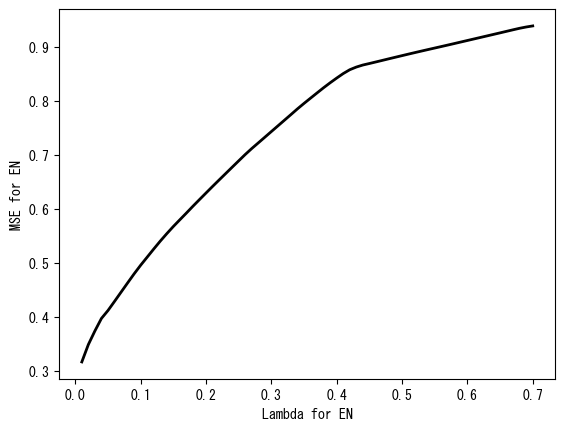

In [ ]:
plt.figure()
plt.plot(ENResult.alphas_, MSEaverageEN[OptimalAlphaNumberEN,:], 'k', linewidth=2)
plt.xlabel("Lambda for EN")
plt.ylabel("MSE for EN")
plt.show()

In [ ]:
OptimalENLambda = ENResult.alpha_
OptimalENAlpha = ENResult.l1_ratio_

In [ ]:
with open('{0:%Y%m%d}_EN_Optimized_hyperparameter_value.txt'.format(now), 'w') as f_en:
    print("Optimal EN Lambda: {}".format(OptimalENLambda), file=f_en)
    print("Optimal EN Alpha: {}".format(OptimalENAlpha), file=f_en)

In [ ]:
EN_model = ElasticNet(l1_ratio=ENResult.l1_ratio_, alpha=ENResult.alpha_)
EN_model.fit(X, y)
print(EN_model)

ElasticNet(alpha=np.float64(0.01), l1_ratio=np.float64(0.39))


In [ ]:
# Save model
with open('{0:%Y%m%d}_EN.pickle'.format(now), mode='wb') as fp_en:
    pickle.dump(EN_model, fp_en)

In [ ]:
ScoreAll[3,:] = EN_model.coef_
CalculatedYAll[:,3] = EN_model.predict(X).T*Originaly.std(ddof=1) + Originaly.mean()
EstimatedYcvAll[:,3] = model_selection.cross_val_predict(EN_model, X, y, cv=Fold_cv).T*Originaly.std(ddof=1) + Originaly.mean()
# Prediction
PredictedYAll[:,3] = EN_model.predict(X_prediction).T*Originaly.std(ddof=1) + Originaly.mean()

In [ ]:
score_model(CalculatedYAll[:,3], EstimatedYcvAll[:,3], RegressionMethodNames[3])

,r2,mae
calculated,0.970323,0.070967
estimatedcv,0.664963,0.233892


### 5. Linear Support Vector Regression (LSVR)

In [ ]:
# Object function
def objective_LSVR(trial):
    param = {
        'C' : trial.suggest_loguniform('C',1e0, 1e2),
        'epsilon' : trial.suggest_loguniform('epsilon',1e-1, 1e1)
    }
    # LSVR
    model_lsvr = svm.SVR(kernel='linear', **param)
    # Prediction
    estimated_y_in_cv = model_selection.cross_val_predict(model_lsvr, X, y, cv=Fold_param)
    estimated_y_in_cv = estimated_y_in_cv * Originaly.std() + Originaly.mean()
    #estimated_y_in_cv = model_lsvr.predict(X)
    r2 = metrics.r2_score(Originaly, estimated_y_in_cv)
    return r2

In [ ]:
# optuna
study_lsvr = optuna.create_study(direction='maximize')
study_lsvr.optimize(objective_LSVR, n_trials=trials_number)

[I 2024-08-19 20:26:08,550] A new study created in memory with name: no-name-dfd5b9e2-0920-4074-9604-07ea9007d259
[I 2024-08-19 20:26:08,566] Trial 0 finished with value: -1.340823404417634 and parameters: {'C': 15.28748571210135, 'epsilon': 6.82007212697228}. Best is trial 0 with value: -1.340823404417634.
[I 2024-08-19 20:26:08,580] Trial 1 finished with value: -1.340823404417634 and parameters: {'C': 4.600341109686244, 'epsilon': 2.406501639372843}. Best is trial 0 with value: -1.340823404417634.
[I 2024-08-19 20:26:08,600] Trial 2 finished with value: 0.311100914015927 and parameters: {'C': 6.251517710234446, 'epsilon': 0.759254268116354}. Best is trial 2 with value: 0.311100914015927.
[I 2024-08-19 20:26:08,617] Trial 3 finished with value: 0.3468289770892292 and parameters: {'C': 1.2448302499909643, 'epsilon': 0.12218600772385833}. Best is trial 3 with value: 0.3468289770892292.
[I 2024-08-19 20:26:08,632] Trial 4 finished with value: -1.340823404417634 and parameters: {'C': 59.2

In [ ]:
with open('{0:%Y%m%d}_LSVR_Optimized_hyperparameter_value.txt'.format(now), 'w') as f_lsvr:
    print(study_lsvr.best_params, file=f_lsvr)

In [ ]:
# Construct LSVR model with the optimal C and epsilon
LSVRResult = svm.SVR(kernel='linear', **study_lsvr.best_params)
LSVRResult.fit(X, y)

SVR(C=10.191504505486547, epsilon=0.414932038090333, kernel='linear')

In [ ]:
# Save model
with open('{0:%Y%m%d}_LSVR.pickle'.format(now), mode='wb') as fp_lsvr:
    pickle.dump(LSVRResult, fp_lsvr)

In [ ]:
CalculatedYAll[:,4] = LSVRResult.predict(X).T*Originaly.std(ddof=1) + Originaly.mean()
ScoreAll[4,:] = LSVRResult.coef_
EstimatedYcvAll[:,4] = model_selection.cross_val_predict(LSVRResult, X, y, cv=Fold_cv).T*Originaly.std(ddof=1) + Originaly.mean()
# Prediction
PredictedYAll[:,4] = LSVRResult.predict(X_prediction).T*Originaly.std(ddof=1) + Originaly.mean()

In [ ]:
score_model(CalculatedYAll[:,4], EstimatedYcvAll[:,4], RegressionMethodNames[4])

,r2,mae
calculated,0.894148,0.174661
estimatedcv,0.647403,0.269390


### 6. Bayesian Ridge Regression (BR)

In [ ]:
# Object function
def objective_BR(trial):
    param = {
        'alpha_1' : trial.suggest_loguniform('alpha_1',1e-8,1e-5),
        'alpha_2' : trial.suggest_loguniform('alpha_2',1e-8,1e-5),
        'lambda_1' : trial.suggest_loguniform('lambda_1',1e-8,1e-5),
        'lambda_2' : trial.suggest_loguniform('lambda_2',1e-8,1e-5)
    }
    # LSVR
    model_br = linear_model.BayesianRidge(**param)
    # Prediction
    estimated_y_in_cv = model_selection.cross_val_predict(model_br, X, y, cv=Fold_param)
    estimated_y_in_cv = estimated_y_in_cv * Originaly.std() + Originaly.mean()
    #estimated_y_in_cv = model_lsvr.predict(X)
    r2 = metrics.r2_score(Originaly, estimated_y_in_cv)
    return r2

In [ ]:
# optuna
study_br = optuna.create_study(direction='maximize')
study_br.optimize(objective_BR, n_trials=trials_number)

[I 2024-08-19 20:26:10,650] A new study created in memory with name: no-name-75d3e8d4-9e24-4c12-b246-ac5c31bece20
[I 2024-08-19 20:26:10,675] Trial 0 finished with value: 0.4983089179340743 and parameters: {'alpha_1': 5.408333286076514e-07, 'alpha_2': 1.9813334704965875e-06, 'lambda_1': 4.734321797586582e-06, 'lambda_2': 8.578253003316937e-07}. Best is trial 0 with value: 0.4983089179340743.
[I 2024-08-19 20:26:10,700] Trial 1 finished with value: 0.49830802715588995 and parameters: {'alpha_1': 3.933080320296413e-08, 'alpha_2': 1.8419237933418778e-07, 'lambda_1': 1.364296105150794e-07, 'lambda_2': 1.0834962086871908e-07}. Best is trial 0 with value: 0.4983089179340743.
[I 2024-08-19 20:26:10,734] Trial 2 finished with value: 0.49830775889223644 and parameters: {'alpha_1': 8.001289787563622e-06, 'alpha_2': 1.0684862614150855e-07, 'lambda_1': 2.7872297234179567e-07, 'lambda_2': 1.7008980980123965e-07}. Best is trial 0 with value: 0.4983089179340743.
[I 2024-08-19 20:26:10,766] Trial 3 fi

In [ ]:
with open('{0:%Y%m%d}_BR_Optimized_hyperparameter_value.txt'.format(now), 'w') as f_br:
    print(study_br.best_params, file=f_br) 

In [ ]:
# Construct BR model with the optimal alpha and lamda
BRResult = linear_model.BayesianRidge(**study_br.best_params)
BRResult.fit(X, y)
# Save model
with open('{0:%Y%m%d}_BR.pickle'.format(now), mode='wb') as fp_br:
    pickle.dump(BRResult, fp_br)

In [ ]:
CalculatedYAll[:,5] = BRResult.predict(X).T*Originaly.std(ddof=1) + Originaly.mean()
ScoreAll[5,:] = BRResult.coef_
EstimatedYcvAll[:,5] = model_selection.cross_val_predict(BRResult, X, y, cv=Fold_cv).T*Originaly.std(ddof=1) + Originaly.mean()
# Prediction
PredictedYBR, PredictedYStdBR = BRResult.predict(X_prediction, return_std=True)
PredictedYAll[:,5] = PredictedYBR.T*Originaly.std(ddof=1) + Originaly.mean()
PredictedYAll[:,6] = PredictedYStdBR*Originaly.std(ddof=1)

In [ ]:
score_model(CalculatedYAll[:,5], EstimatedYcvAll[:,5], RegressionMethodNames[5])

,r2,mae
calculated,0.966526,0.077323
estimatedcv,0.502855,0.282910


### 7. Non-Linear Support Vector Regression (NLSVR)

In [ ]:
# Object function
def objective_NLSVR(trial):
    param = {
        'C' : trial.suggest_loguniform('C', 1e0, 1e2),
        'epsilon' : trial.suggest_loguniform('epsilon', 1e-1, 1e1)
    }
    # LSVR
    model_lsvr = SVR(kernel='rbf', **param, gamma='auto')
    # Prediction
    estimated_y_in_cv = model_selection.cross_val_predict(model_lsvr, X, y, cv=Fold_param)
    estimated_y_in_cv = estimated_y_in_cv * Originaly.std() + Originaly.mean()
    #estimated_y_in_cv = model_lsvr.predict(X)
    r2 = metrics.r2_score(Originaly, estimated_y_in_cv)
    return r2

In [ ]:
# optuna
study_nlsvr = optuna.create_study(direction='maximize')
study_nlsvr.optimize(objective_NLSVR, n_trials=trials_number)

[I 2024-08-19 20:26:13,882] A new study created in memory with name: no-name-cfc2c82d-1dd6-42a3-96d9-5d4dffd2afec
[I 2024-08-19 20:26:13,902] Trial 0 finished with value: -1.340823404417634 and parameters: {'C': 33.921293223282035, 'epsilon': 4.86087182624562}. Best is trial 0 with value: -1.340823404417634.
[I 2024-08-19 20:26:13,919] Trial 1 finished with value: -1.340823404417634 and parameters: {'C': 7.814177228158424, 'epsilon': 7.8040212131486015}. Best is trial 0 with value: -1.340823404417634.
[I 2024-08-19 20:26:13,932] Trial 2 finished with value: -1.340823404417634 and parameters: {'C': 2.0218497200454095, 'epsilon': 2.3945612548525137}. Best is trial 0 with value: -1.340823404417634.
[I 2024-08-19 20:26:13,949] Trial 3 finished with value: -1.340823404417634 and parameters: {'C': 2.169432591645569, 'epsilon': 7.148658310980948}. Best is trial 0 with value: -1.340823404417634.
[I 2024-08-19 20:26:13,964] Trial 4 finished with value: -1.340823404417634 and parameters: {'C': 7

In [ ]:
with open('{0:%Y%m%d}_NLSVR_Optimized_hyperparameter_value.txt'.format(now), 'w') as f_nlsvr:
    print(study_nlsvr.best_params, file=f_nlsvr)

In [ ]:
# Construct NLSVR model with the optimal C and epsilon
NLSVRResult = SVR(kernel='rbf',**study_nlsvr.best_params, gamma='auto')
NLSVRResult.fit(X, y)
# Save model
with open('{0:%Y%m%d}_NLSVR.pickle'.format(now), mode='wb') as fp_nlsvr:
    pickle.dump(NLSVRResult, fp_nlsvr)

In [ ]:
CalculatedYAll[:,6] = NLSVRResult.predict(X).T*Originaly.std(ddof=1) + Originaly.mean()
EstimatedYcvAll[:,6] = model_selection.cross_val_predict(NLSVRResult, X, y, cv=Fold_cv).T*Originaly.std(ddof=1) + Originaly.mean()
# Prediction
PredictedYAll[:,7] = NLSVRResult.predict(X_prediction).T*Originaly.std(ddof=1) + Originaly.mean()

In [ ]:
score_model(CalculatedYAll[:,6], EstimatedYcvAll[:,6], RegressionMethodNames[6])

,r2,mae
calculated,0.986561,0.069281
estimatedcv,0.212040,0.370967


### 8. Kernel Ridge (KR)

In [ ]:
# Object function
def objective_KR(trial):
    # alpha
    param = {
        'alpha' : trial.suggest_loguniform('alpha', 1e-3, 1e0),
        'gamma' : trial.suggest_loguniform('gamma', 1e-2, 1e5)
    }
    # KernelRidge regression
    model_kr = KernelRidge(kernel='rbf', **param)
    # Prediction
    estimated_y_in_cv = model_selection.cross_val_predict(model_kr, X, y, cv=Fold_param)
    estimated_y_in_cv = estimated_y_in_cv * Originaly.std() + Originaly.mean()
    # estimated_y_in_cv = model_kr.predict(X)
    r2 = metrics.r2_score(Originaly, estimated_y_in_cv)
    return r2

In [ ]:
# optuna
study_kr = optuna.create_study(direction='maximize')
study_kr.optimize(objective_KR, n_trials=trials_number)

[I 2024-08-19 20:26:16,170] A new study created in memory with name: no-name-d6cb3629-f4f6-45d8-bedd-c8662aa5e5be
[I 2024-08-19 20:26:16,196] Trial 0 finished with value: 0.0 and parameters: {'alpha': 0.016320394738262058, 'gamma': 863.5391889672352}. Best is trial 0 with value: 0.0.
[I 2024-08-19 20:26:16,219] Trial 1 finished with value: 9.046181466132452e-07 and parameters: {'alpha': 0.012592123965351538, 'gamma': 36.3057183651724}. Best is trial 1 with value: 9.046181466132452e-07.
[I 2024-08-19 20:26:16,244] Trial 2 finished with value: 0.0 and parameters: {'alpha': 0.06901506308212743, 'gamma': 4336.911095964997}. Best is trial 1 with value: 9.046181466132452e-07.
[I 2024-08-19 20:26:16,276] Trial 3 finished with value: 0.16049028663607912 and parameters: {'alpha': 0.001200323309259599, 'gamma': 0.10761492201721187}. Best is trial 3 with value: 0.16049028663607912.
[I 2024-08-19 20:26:16,301] Trial 4 finished with value: 0.01281227132018481 and parameters: {'alpha': 0.10837044596

In [ ]:
with open('{0:%Y%m%d}_KR_Optimized_hyperparameter_value.txt'.format(now), 'w') as f_kr:
    print(study_kr.best_params, file=f_kr)

In [ ]:
# Construct SVR model with the optimal alpha
KRResult = KernelRidge(kernel='rbf', **study_kr.best_params)
KRResult.fit(X, y)
# Save model
with open('{0:%Y%m%d}_KR.pickle'.format(now), mode='wb') as fp_kr:
    pickle.dump(KRResult, fp_kr)

In [ ]:
CalculatedYAll[:,7] = KRResult.predict(X).T*Originaly.std(ddof=1) + Originaly.mean()
EstimatedYcvAll[:,7] = model_selection.cross_val_predict(KRResult, X, y, cv=Fold_cv).T*Originaly.std(ddof=1) + Originaly.mean()
# Prediction
PredictedYAll[:,8] = KRResult.predict(X_prediction).T*Originaly.std(ddof=1) + Originaly.mean()

In [ ]:
score_model(CalculatedYAll[:,7], EstimatedYcvAll[:,7], RegressionMethodNames[7])

,r2,mae
calculated,0.969746,0.077378
estimatedcv,0.526763,0.276345


### 9. Random Forest (RF)

In [ ]:
def objective_RF(trial):

    rf_tree = trial.suggest_int("n_estimators", 10, 100)
    rf_max_features = trial.suggest_categorical("max_features", ['sqrt', 'log2'])
    model_rf = RandomForestRegressor(
        n_estimators=rf_tree, 
        max_features=rf_max_features, 
        oob_score=True       
    )    

    estimated_y_in_cv = model_selection.cross_val_predict(model_rf, X, y, cv=Fold_param)
    estimated_y_in_cv = estimated_y_in_cv * Originaly.std() + Originaly.mean()
    r2 = metrics.r2_score(Originaly, estimated_y_in_cv)
    return r2

In [ ]:
# optuna
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_RF, n_trials=trials_number)

[I 2024-08-19 20:26:19,138] A new study created in memory with name: no-name-3b31acfd-4b84-49ac-9545-7c3c2342a1fb
[I 2024-08-19 20:26:19,390] Trial 0 finished with value: 0.000443270463735268 and parameters: {'n_estimators': 12, 'max_features': 'log2'}. Best is trial 0 with value: 0.000443270463735268.
[I 2024-08-19 20:26:19,972] Trial 1 finished with value: 0.09181384577353735 and parameters: {'n_estimators': 32, 'max_features': 'log2'}. Best is trial 1 with value: 0.09181384577353735.
[I 2024-08-19 20:26:20,922] Trial 2 finished with value: -0.0878768050472869 and parameters: {'n_estimators': 52, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.09181384577353735.
[I 2024-08-19 20:26:22,722] Trial 3 finished with value: 0.11528599582104748 and parameters: {'n_estimators': 100, 'max_features': 'log2'}. Best is trial 3 with value: 0.11528599582104748.
[I 2024-08-19 20:26:24,503] Trial 4 finished with value: 0.11478540098519441 and parameters: {'n_estimators': 100, 'max_features': 

In [ ]:
with open('{0:%Y%m%d}_RF_Optimized_hyperparameter_value.txt'.format(now), 'w') as f_rf:
    print(study_rf.best_params, file=f_rf)

In [ ]:
RFResult = RandomForestRegressor(**study_rf.best_params, oob_score=True)
RFResult.fit(X, y)
# Save model
with open('{0:%Y%m%d}_RF.pickle'.format(now), mode='wb') as fp_rf:
    pickle.dump(RFResult, fp_rf)

In [ ]:
ScoreAll[6,:] = RFResult.feature_importances_.T
CalculatedYAll[:,8] = RFResult.predict(X).T*Originaly.std(ddof=1) + Originaly.mean()
EstimatedYcvAll[:,8] = model_selection.cross_val_predict(RFResult, X, y, cv=Fold_cv).T*Originaly.std(ddof=1) + Originaly.mean()
# Prediction
PredictedYAll[:,9] = RFResult.predict(X_prediction).T*Originaly.std(ddof=1) + Originaly.mean()

In [ ]:
score_model(CalculatedYAll[:,8], EstimatedYcvAll[:,8], RegressionMethodNames[8])

,r2,mae
calculated,0.785585,0.182848
estimatedcv,-0.006236,0.419033


### 10. XGBoost (XGB)

In [ ]:
# Object function
def objective_XGB(trial):
    param = {
        "n_estimators" : trial.suggest_int('n_estimators', 0, 1000),
        "max_depth" : trial.suggest_int('max_depth', 1, 20),
        "min_child_weight" : trial.suggest_int('min_child_weight', 1, 20),
        "subsample" : trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1),
        "colsample_bytree" : trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)
    }

    model_xgb = xgb.XGBRegressor(**param)
    estimated_y_in_cv = model_selection.cross_val_predict(model_xgb, X, y, cv=Fold_param)
    estimated_y_in_cv = estimated_y_in_cv * Originaly.std() + Originaly.mean()
    r2 = metrics.r2_score(Originaly, estimated_y_in_cv)
    return r2

In [ ]:
# optuna
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_XGB, n_trials=trials_number)

[I 2024-08-19 20:27:19,020] A new study created in memory with name: no-name-07eba375-1e96-430c-99b8-e86872024a67
[I 2024-08-19 20:27:21,495] Trial 0 finished with value: -0.016302224323416548 and parameters: {'n_estimators': 874, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial 0 with value: -0.016302224323416548.
[I 2024-08-19 20:27:22,762] Trial 1 finished with value: -0.021288060852582724 and parameters: {'n_estimators': 401, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: -0.016302224323416548.
[I 2024-08-19 20:27:25,509] Trial 2 finished with value: 0.1541866673616834 and parameters: {'n_estimators': 996, 'max_depth': 16, 'min_child_weight': 3, 'subsample': 0.5, 'colsample_bytree': 0.6}. Best is trial 2 with value: 0.1541866673616834.
[I 2024-08-19 20:27:27,371] Trial 3 finished with value: -0.1843532611948322 and parameters: {'n_estimators': 602, 'max_depth': 18, 'min_

In [ ]:
with open('{0:%Y%m%d}_XGB_Optimized_hyperparameter_value.txt'.format(now), 'w') as f_xgb:
    print(study_xgb.best_params, file=f_xgb)

In [ ]:
XGBResult = xgb.XGBRegressor(**study_xgb.best_params, importance_type='total_gain')
XGBResult.fit(X, y)
# Save model
with open('{0:%Y%m%d}_XGB.pickle'.format(now), mode='wb') as fp_xgb:
    pickle.dump(XGBResult, fp_xgb)

In [ ]:
ScoreAll[7,:] = XGBResult.feature_importances_.T
CalculatedYAll[:,9] = XGBResult.predict(X).T*Originaly.std(ddof=1) + Originaly.mean()
EstimatedYcvAll[:,9] = model_selection.cross_val_predict(XGBResult, X, y, cv=Fold_cv).T*Originaly.std(ddof=1) + Originaly.mean()
# Prediction
PredictedYAll[:,10] = XGBResult.predict(X_prediction).T*Originaly.std(ddof=1) + Originaly.mean()

In [ ]:
score_model(CalculatedYAll[:,9], EstimatedYcvAll[:,9], RegressionMethodNames[9])

,r2,mae
calculated,0.752666,0.246113
estimatedcv,0.277818,0.367319


### 11. Gaussian Process (GP)

In [ ]:
# Construct GP model
kernel = (gp.kernels.ConstantKernel(constant_value=1, constant_value_bounds=(1e-2, 1e2))
          * gp.kernels.RBF(length_scale=1, length_scale_bounds=(0.1, 10))
          + gp.kernels.WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-4, 1)))
GPResult = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=0)
GPResult.fit(X, y)
# Save model
with open('{0:%Y%m%d}_GP.pickle'.format(now), mode='wb') as fp_gp:
    pickle.dump(GPResult, fp_gp)

In [ ]:
with open('{0:%Y%m%d}_GP_Optimized_hyperparameter_value.txt'.format(now), 'w') as f_gp:
    print("Optimal GP kernel: {0}".format(GPResult.kernel_), file=f_gp)

In [ ]:
CalculatedYAll[:,10] = GPResult.predict(X).T*Originaly.std(ddof=1) + Originaly.mean()
# Estimate objective variable (Y) and Calculate variance of estimated Y, based on the GP model.
EstimatedYcvAll[:,10] = model_selection.cross_val_predict(GPResult, X, y, cv=Fold_cv).T*Originaly.std(ddof=1) + Originaly.mean()
# Prediction
PredictedYGP, PredictedYStdGP = GPResult.predict(X_prediction, return_std=True)
PredictedYAll[:,11] = PredictedYGP.T*Originaly.std(ddof=1) + Originaly.mean()
PredictedYAll[:,12] = PredictedYStdGP*Originaly.std(ddof=1)

In [ ]:
score_model(CalculatedYAll[:,10], EstimatedYcvAll[:,10], RegressionMethodNames[10])

,r2,mae
calculated,0.980422,0.066786
estimatedcv,0.342256,0.328897


### Results

In [ ]:
# Calculate r^2
def calc_r2( ActualY, EstimatedY ):
    return metrics.r2_score(ActualY, EstimatedY)

# Calculate Mean Absolute Error 平均絶対誤差
def calc_mae( ActualY, EstimatedY ):
    return np.average(abs(ActualY-EstimatedY))

# Calculate RMSE
#def calc_rmse( ActualY, EstimatedY ):
#    return( math.sqrt( sum( (ActualY-EstimatedY )**2 ) / ActualY.shape[0]) )

In [ ]:
# Make YYplot of calculatedy
def make_yyplot_cal( ActualY, EstimatedY, YMax, YMin, EstimatedYName ):
    plt.figure(figsize=figure.figaspect(1))
    plt.scatter(ActualY,EstimatedY)
    plt.plot([YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin)], [YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin)], 'k-')
    plt.ylim(YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin))
    plt.xlim(YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin))
    plt.xlabel("Actual Y")
    plt.ylabel(EstimatedYName)
    plt.savefig('{0:%Y%m%d}_{1}_calculatedY.png'.format(now, RegressionMethodNames[RegressionMethodNumber]), bbox_inches="tight")
    plt.show()

In [ ]:
# Make YYplot of estimatedy
def make_yyplot_est( ActualY, EstimatedY, YMax, YMin, EstimatedYName, Validation ):
    plt.figure(figsize=figure.figaspect(1))
    plt.scatter(ActualY,EstimatedY)
    plt.plot([YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin)], [YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin)], 'k-')
    plt.ylim(YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin))
    plt.xlim(YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin))
    plt.xlabel("Actual Y")
    plt.ylabel(EstimatedYName)
    plt.savefig('{0:%Y%m%d}_{1}_estimatedY{2}.png'.format(now, RegressionMethodNames[RegressionMethodNumber], Validation), bbox_inches="tight")
    plt.show()

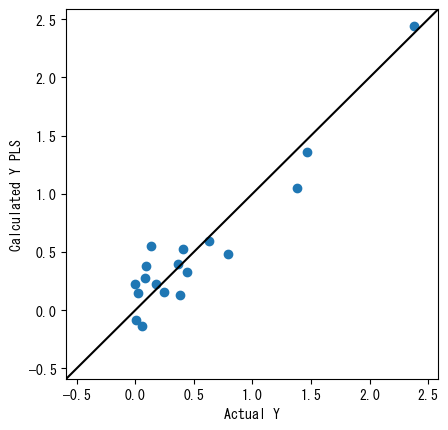

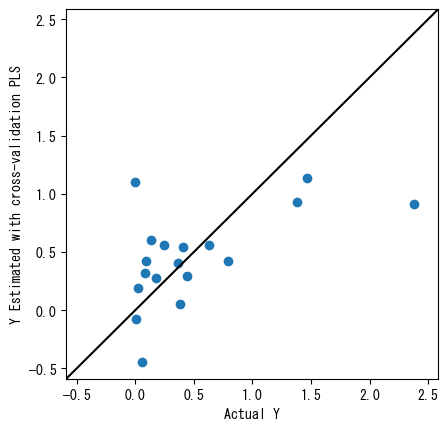

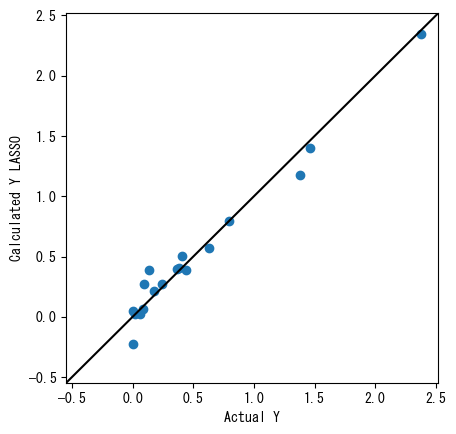

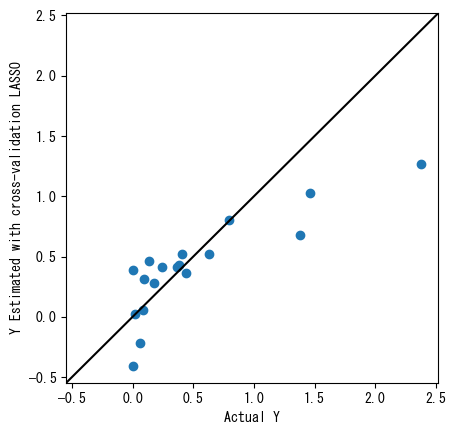

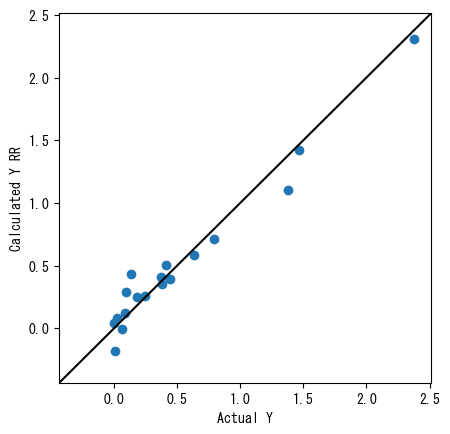

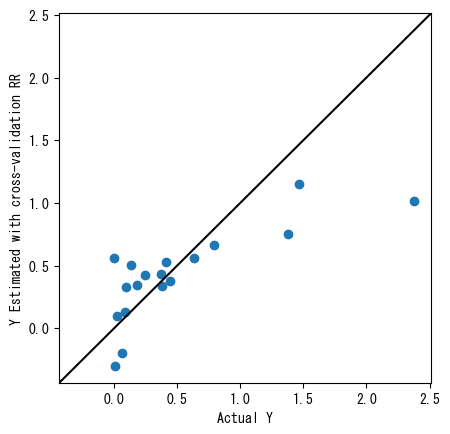

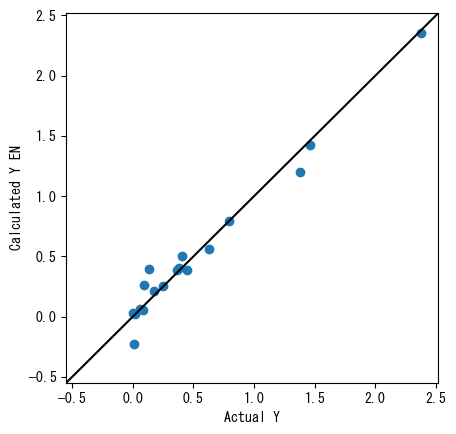

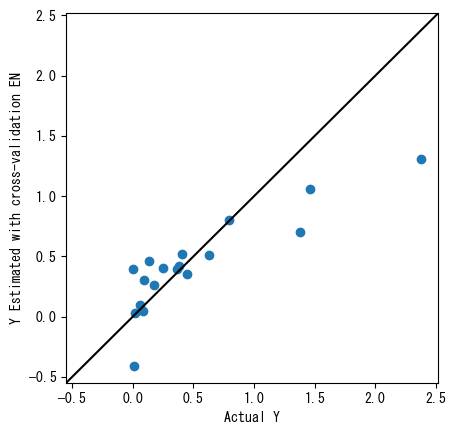

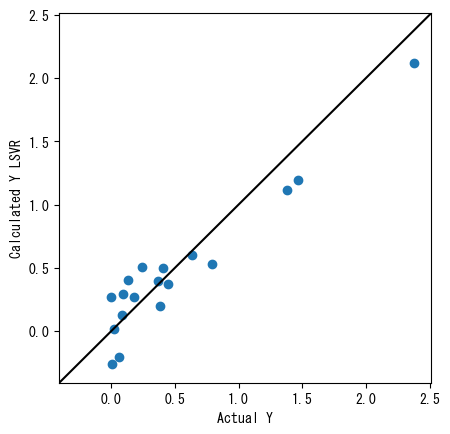

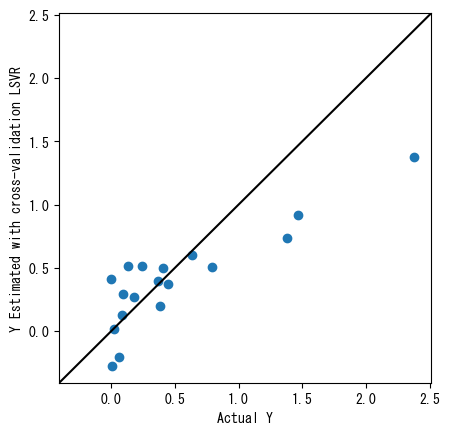

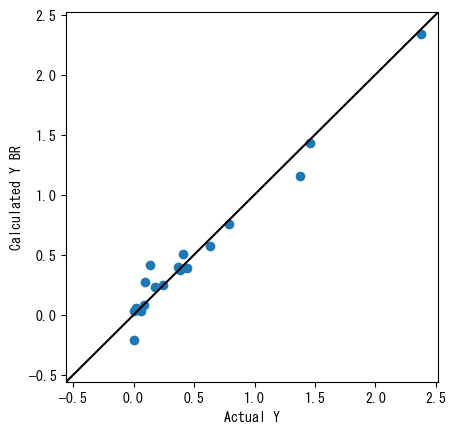

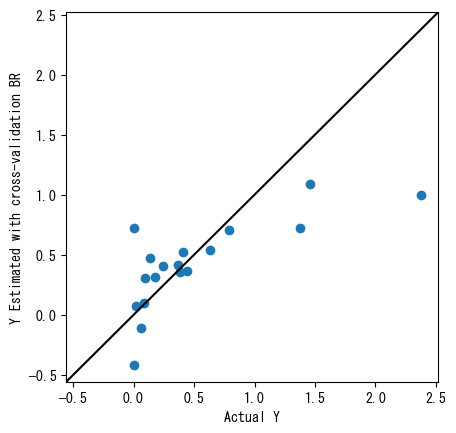

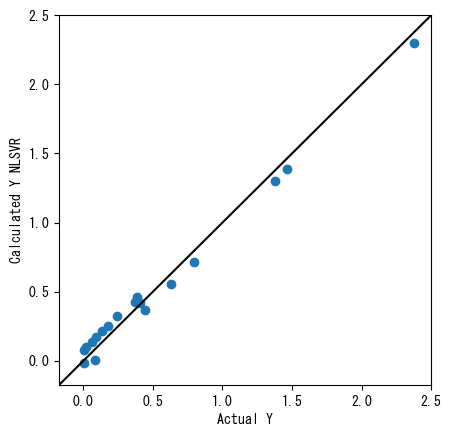

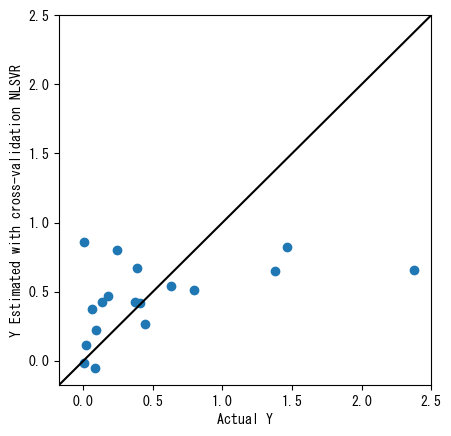

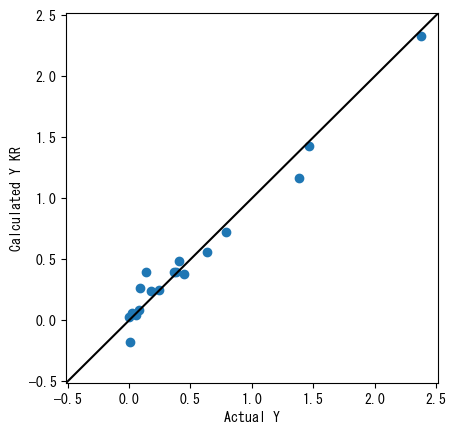

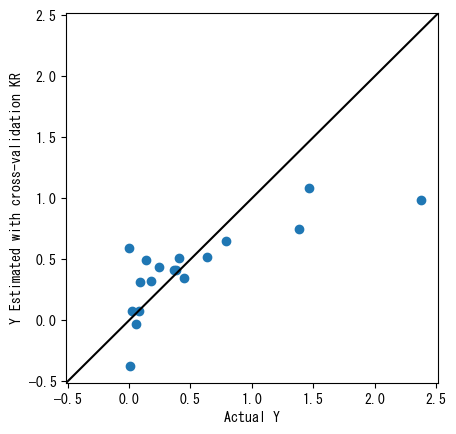

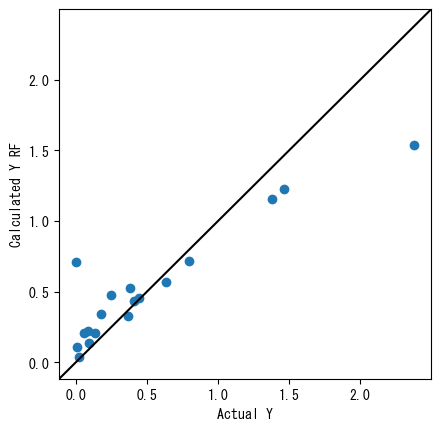

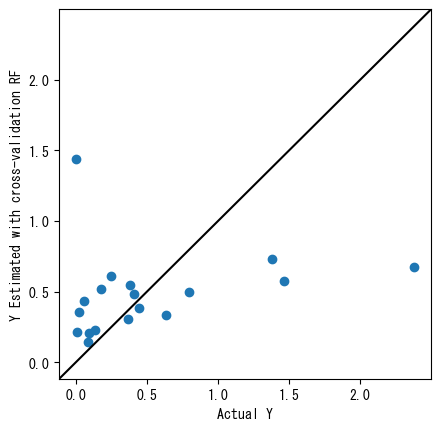

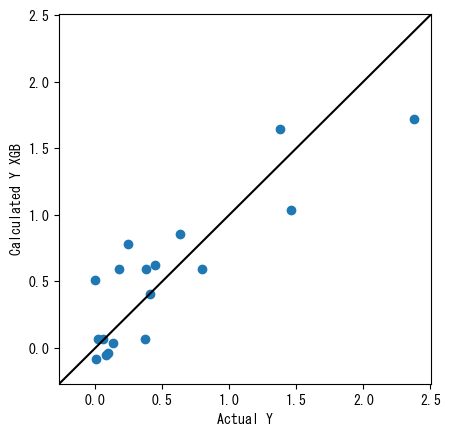

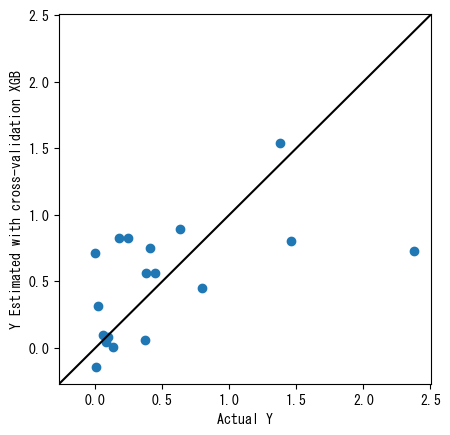

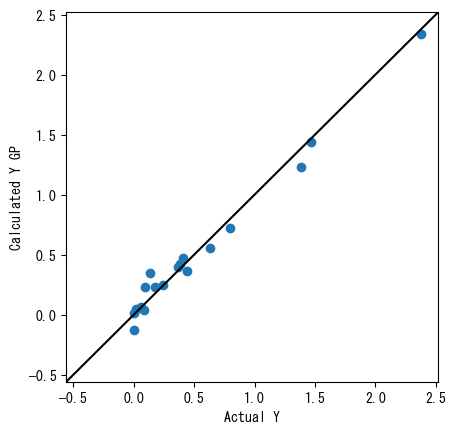

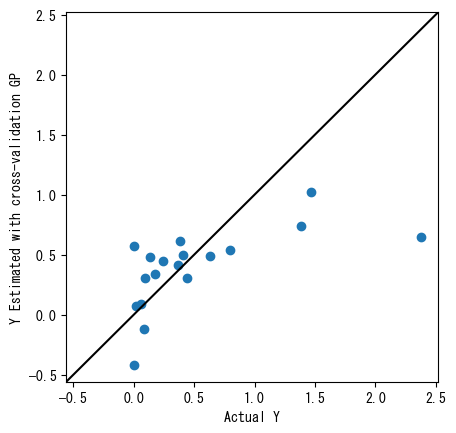

In [ ]:
# Calculate statistics and show YY plots
StatisticsAll = np.zeros( (4, NumberOfRegressionMethods) )
for RegressionMethodNumber in range(0,NumberOfRegressionMethods):
    YMax = np.max( np.array([np.max(Originaly), np.max(CalculatedYAll[:,RegressionMethodNumber]), np.max(EstimatedYcvAll[:,RegressionMethodNumber])]))
    YMin = np.min( np.array([np.min(Originaly), np.min(CalculatedYAll[:,RegressionMethodNumber]), np.min(EstimatedYcvAll[:,RegressionMethodNumber])]))
    StatisticsAll[0,RegressionMethodNumber] = calc_r2(Originaly, CalculatedYAll[:,RegressionMethodNumber])
    StatisticsAll[1,RegressionMethodNumber] = calc_mae(Originaly, CalculatedYAll[:,RegressionMethodNumber])
    StatisticsAll[2,RegressionMethodNumber] = calc_r2(Originaly, EstimatedYcvAll[:,RegressionMethodNumber])
    StatisticsAll[3,RegressionMethodNumber] = calc_mae(Originaly, EstimatedYcvAll[:,RegressionMethodNumber])
    if ShowYYplots != 0:
        make_yyplot_cal( Originaly, CalculatedYAll[:,RegressionMethodNumber], YMax, YMin, "Calculated Y" + " " + RegressionMethodNames[RegressionMethodNumber])
        make_yyplot_est( Originaly, EstimatedYcvAll[:,RegressionMethodNumber], YMax, YMin, "Y Estimated with cross-validation" + " " + RegressionMethodNames[RegressionMethodNumber], "cv")

In [ ]:
# Show results
with open('{0:%Y%m%d}_total_Optimized_hyperparameter_values.txt'.format(now), 'w') as f_all:
    print("Optimal number of PLS components: {0}".format(optimal_pls_component_number), file=f_all)
    print("Optimal LASSO lambda: {0}".format(OptimalLASSOLambda), file=f_all)
    print("Optimal RR weight: {0}".format(OptimalRRLambda), file=f_all)
    print("Optimal EN lambda: {0}".format(OptimalENLambda), file=f_all)
    print("Optimal EN alpha: {0}".format(OptimalENAlpha), file=f_all)
    print("Optimal LSVR C: {0}".format(study_lsvr.best_params['C']), file=f_all)
    print("Optimal LSVR Epsilon: {0}".format(study_lsvr.best_params['epsilon']), file=f_all)
    print("Optimal BR alpha1: {0}".format(study_br.best_params['alpha_1']), file=f_all)
    print("Optimal BR alpha2: {0}".format(study_br.best_params['alpha_2']), file=f_all)
    print("Optimal BR lamda1: {0}".format(study_br.best_params['lambda_1']), file=f_all)
    print("Optimal BR lamda2: {0}".format(study_br.best_params['lambda_2']), file=f_all)
    print("Optimal NLSVR C: {0}".format(study_nlsvr.best_params['C']), file=f_all)
    print("Optimal NLSVR Epsilon: {0}".format(study_nlsvr.best_params['epsilon']), file=f_all)
    print("Optimal KR Alpha: {0}".format(study_kr.best_params['alpha']), file=f_all)
    print("Optimal KR Gamma: {0}".format(study_kr.best_params['gamma']), file=f_all)
    print("Optimal RF n_estimators: {0}".format(study_rf.best_params['n_estimators']), file=f_all)
    print("Optimal RF max_features: {0}".format(study_rf.best_params['max_features']), file=f_all)
    print("Optimal XGB n_estimators: {0}".format(study_xgb.best_params['n_estimators']), file=f_all)
    print("Optimal XGB max_depth: {0}".format(study_xgb.best_params['max_depth']), file=f_all)
    print("Optimal XGB min_child_weight: {0}".format(study_xgb.best_params['min_child_weight']), file=f_all)
    print("Optimal XGB subsample: {0}".format(study_xgb.best_params['subsample']), file=f_all)
    print("Optimal XGB colsample_bytree: {0}".format(study_xgb.best_params['colsample_bytree']), file=f_all)
    print("Optimal GP kernel: {0}".format(GPResult.kernel_), file=f_all)

In [ ]:
# Save results
CalculatedYAll = pd.DataFrame(CalculatedYAll)
CalculatedYAll.index = datapd.index
CalculatedYAll.columns = RegressionMethodNames
CalculatedYAll = pd.concat( [actualy2, CalculatedYAll], axis=1 )
CalculatedYAll.to_csv( "{0:%Y%m%d}_CalculatedY.csv".format(now), encoding='cp932' )
EstimatedYcvAll = pd.DataFrame(EstimatedYcvAll)
EstimatedYcvAll.index = datapd.index
EstimatedYcvAll.columns = RegressionMethodNames
EstimatedYcvAll = pd.concat( [actualy2, EstimatedYcvAll], axis=1 )
EstimatedYcvAll.to_csv( "{0:%Y%m%d}_EstimatedYcv.csv".format(now), encoding='cp932' )
ScoreAll = pd.DataFrame(ScoreAll)
ScoreAll.columns = datapd.columns
ScoreAll.index = ScoreNames
ScoreAll.to_csv( "{0:%Y%m%d}_ScoreAll.csv".format(now), encoding='cp932' )
StatisticsAll = pd.DataFrame(StatisticsAll)
StatisticsAll.columns = RegressionMethodNames
StatisticsAll.index = StatisticsNames[:4]
StatisticsAll = StatisticsAll.T.sort_values("r2cv", ascending=False)
StatisticsAll.to_csv( "{0:%Y%m%d}_StatisticAllcv.csv".format(now) )
PredictedYAll = pd.DataFrame(PredictedYAll)
PredictedYAll.index = data_predictionpd.index
PredictedYAll.columns = PredictedRegressionMethodNames
PredictedYAll.to_csv( "{0:%Y%m%d}_PredictedY.csv".format(now), encoding='cp932' )

In [ ]:
# Compare models
print(StatisticsAll)

             r2       MAE      r2cv     MAEcv
EN     0.970323  0.070967  0.664963  0.233892
LSVR   0.894148  0.174661  0.647403  0.269390
LASSO  0.968319  0.078221  0.631547  0.254877
RR     0.958536  0.094776  0.548570  0.278246
KR     0.969746  0.077378  0.526763  0.276345
BR     0.966526  0.077323  0.502855  0.282910
GP     0.980422  0.066786  0.342256  0.328897
PLS    0.895217  0.168213  0.313591  0.369294
XGB    0.752666  0.246113  0.277818  0.367319
NLSVR  0.986561  0.069281  0.212040  0.370967
RF     0.785585  0.182848 -0.006236  0.419033


### Permuation importance

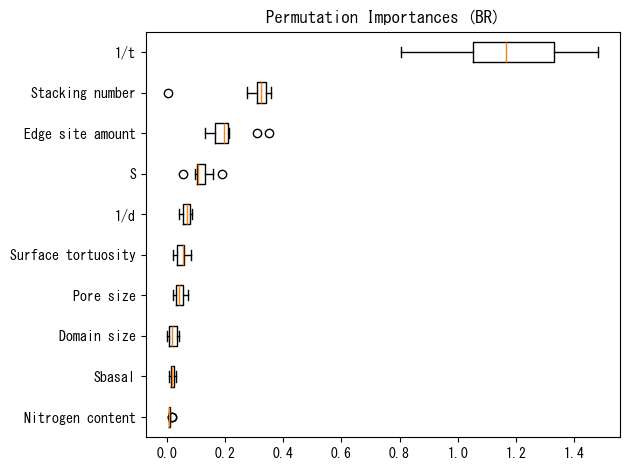

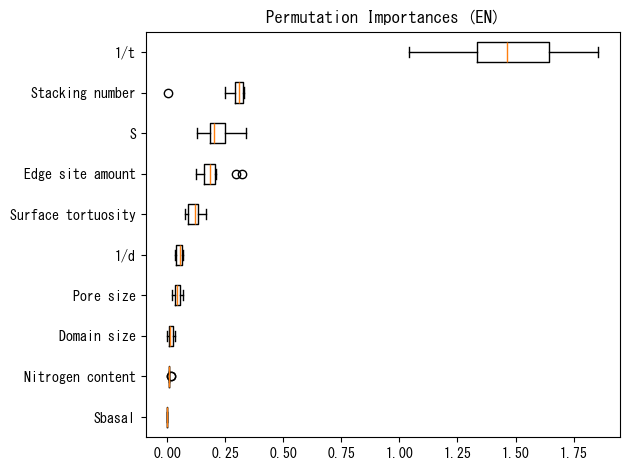

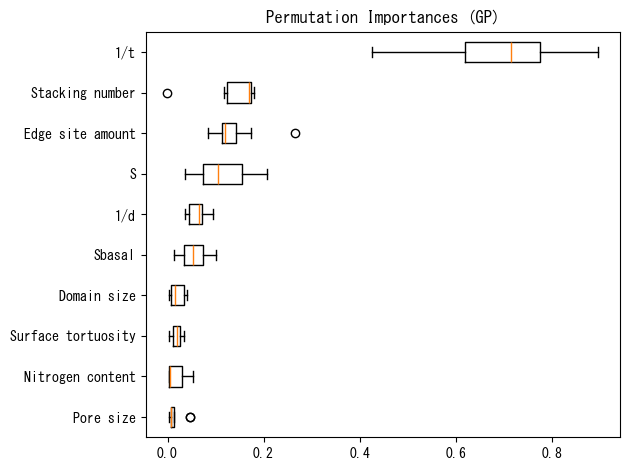

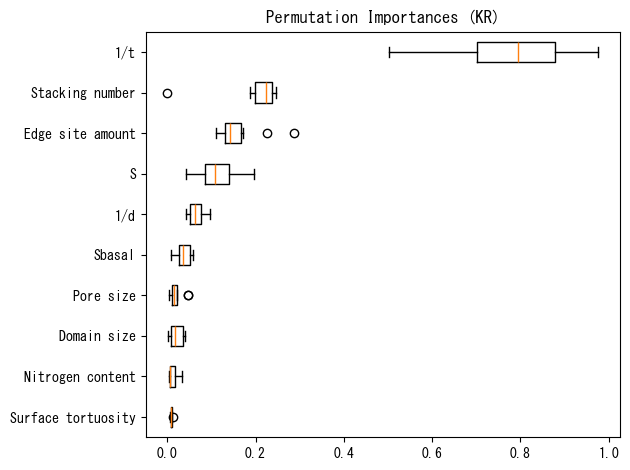

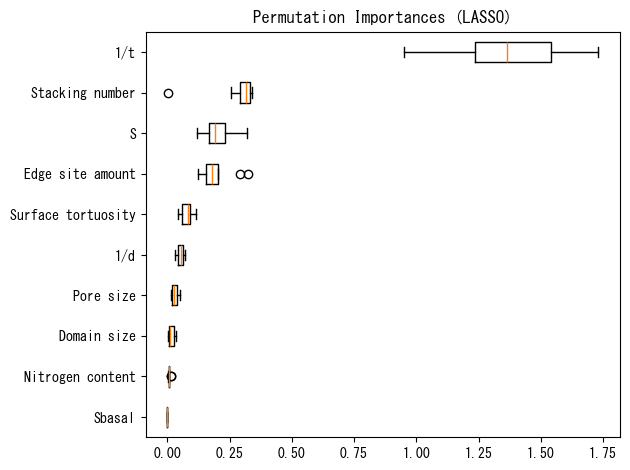

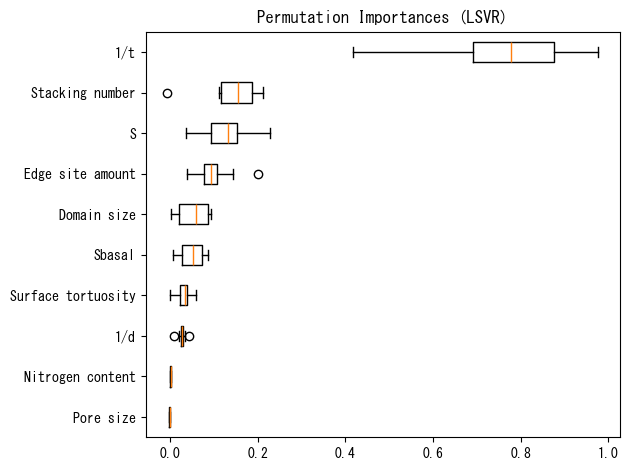

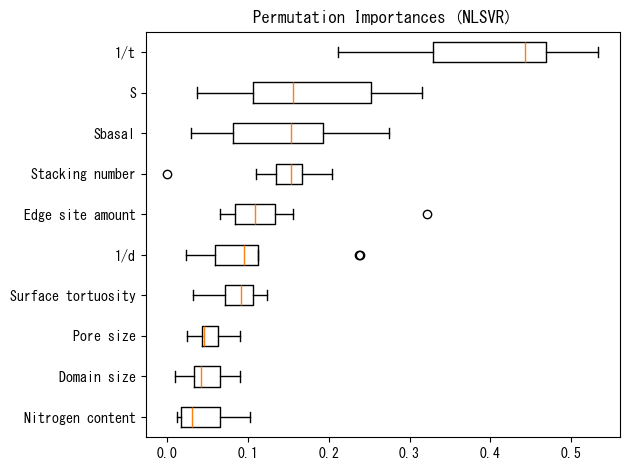

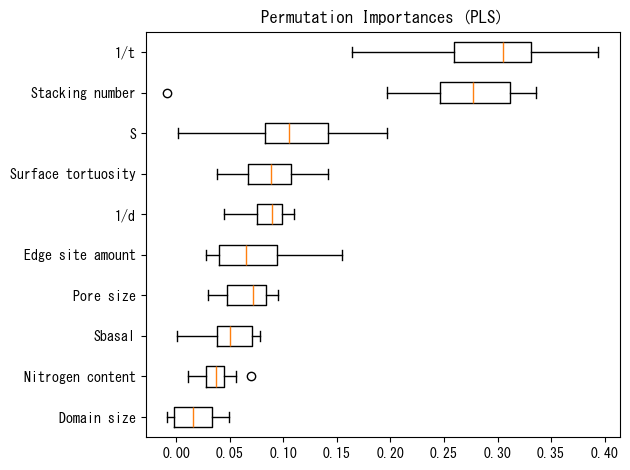

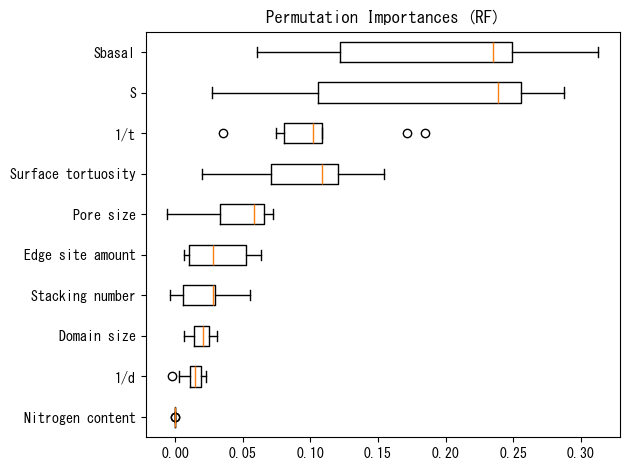

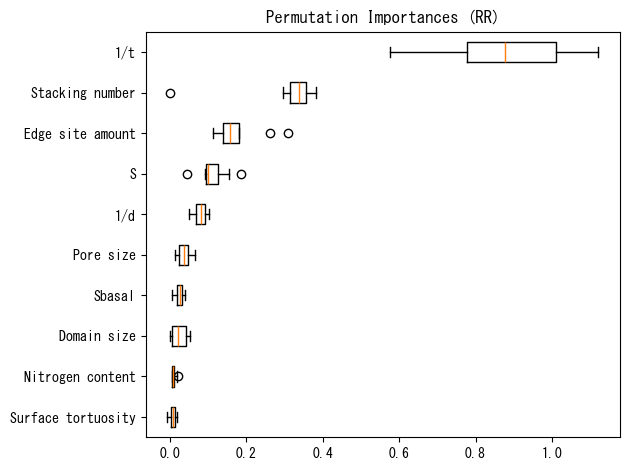

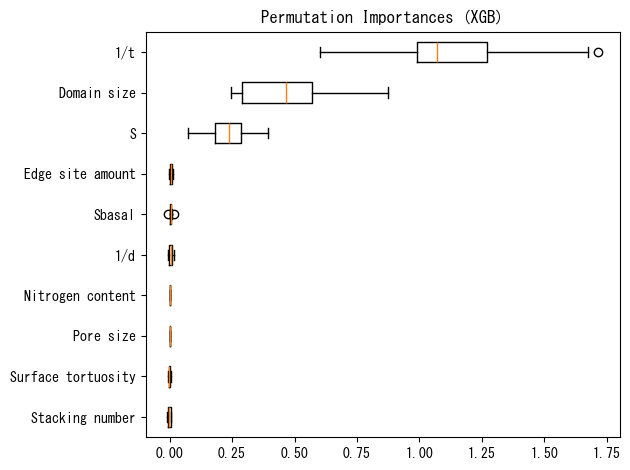

In [ ]:
if CalPermutationimportance != 0:
    path_list = glob.glob('*.pickle')
    count = 0
    models = []
    for i in path_list:
        file = os.path.basename(i) 
        # 拡張子を除いたファイル名取得。9文字目以降の名前を取得することでモデル名を取得
        model_name = os.path.splitext(file)[0][9:]
        models.append(model_name)
        #print(model_name)
        with open(file, "rb") as f:
            model = pickle.load(f)
        if model_name in RegressionMethodNames:
            result = permutation_importance(model, X, y, n_repeats=10,
                                    random_state=42, n_jobs=2)
            sorted_idx = result.importances_mean.argsort()[::-1]
            ran_num = np.arange(len(sorted_idx))
            ran_num = ran_num[sorted_idx]
            fig, ax = plt.subplots()
            ax.boxplot(result.importances[ran_num[:sel_num][::-1]].T,
               vert=False, labels=datapd.columns[ran_num[:sel_num][::-1]])
            ax.set_title("Permutation Importances ({})".format(model_name))
            fig.tight_layout()
            plt.savefig('{0:%Y%m%d}_{1}_Permutationimportance.png'.format(now, model_name), bbox_inches="tight")
            plt.show()
            Permutationimportance[count,:] = result.importances_mean
            count += 1
    Permutationimportance = pd.DataFrame(Permutationimportance)
    Permutationimportance.columns = datapd.columns
    Permutationimportance.index = models
    Permutationimportance.to_csv ( "{0:%Y%m%d}_Permutationimportance.csv".format(now), encoding='cp932' )

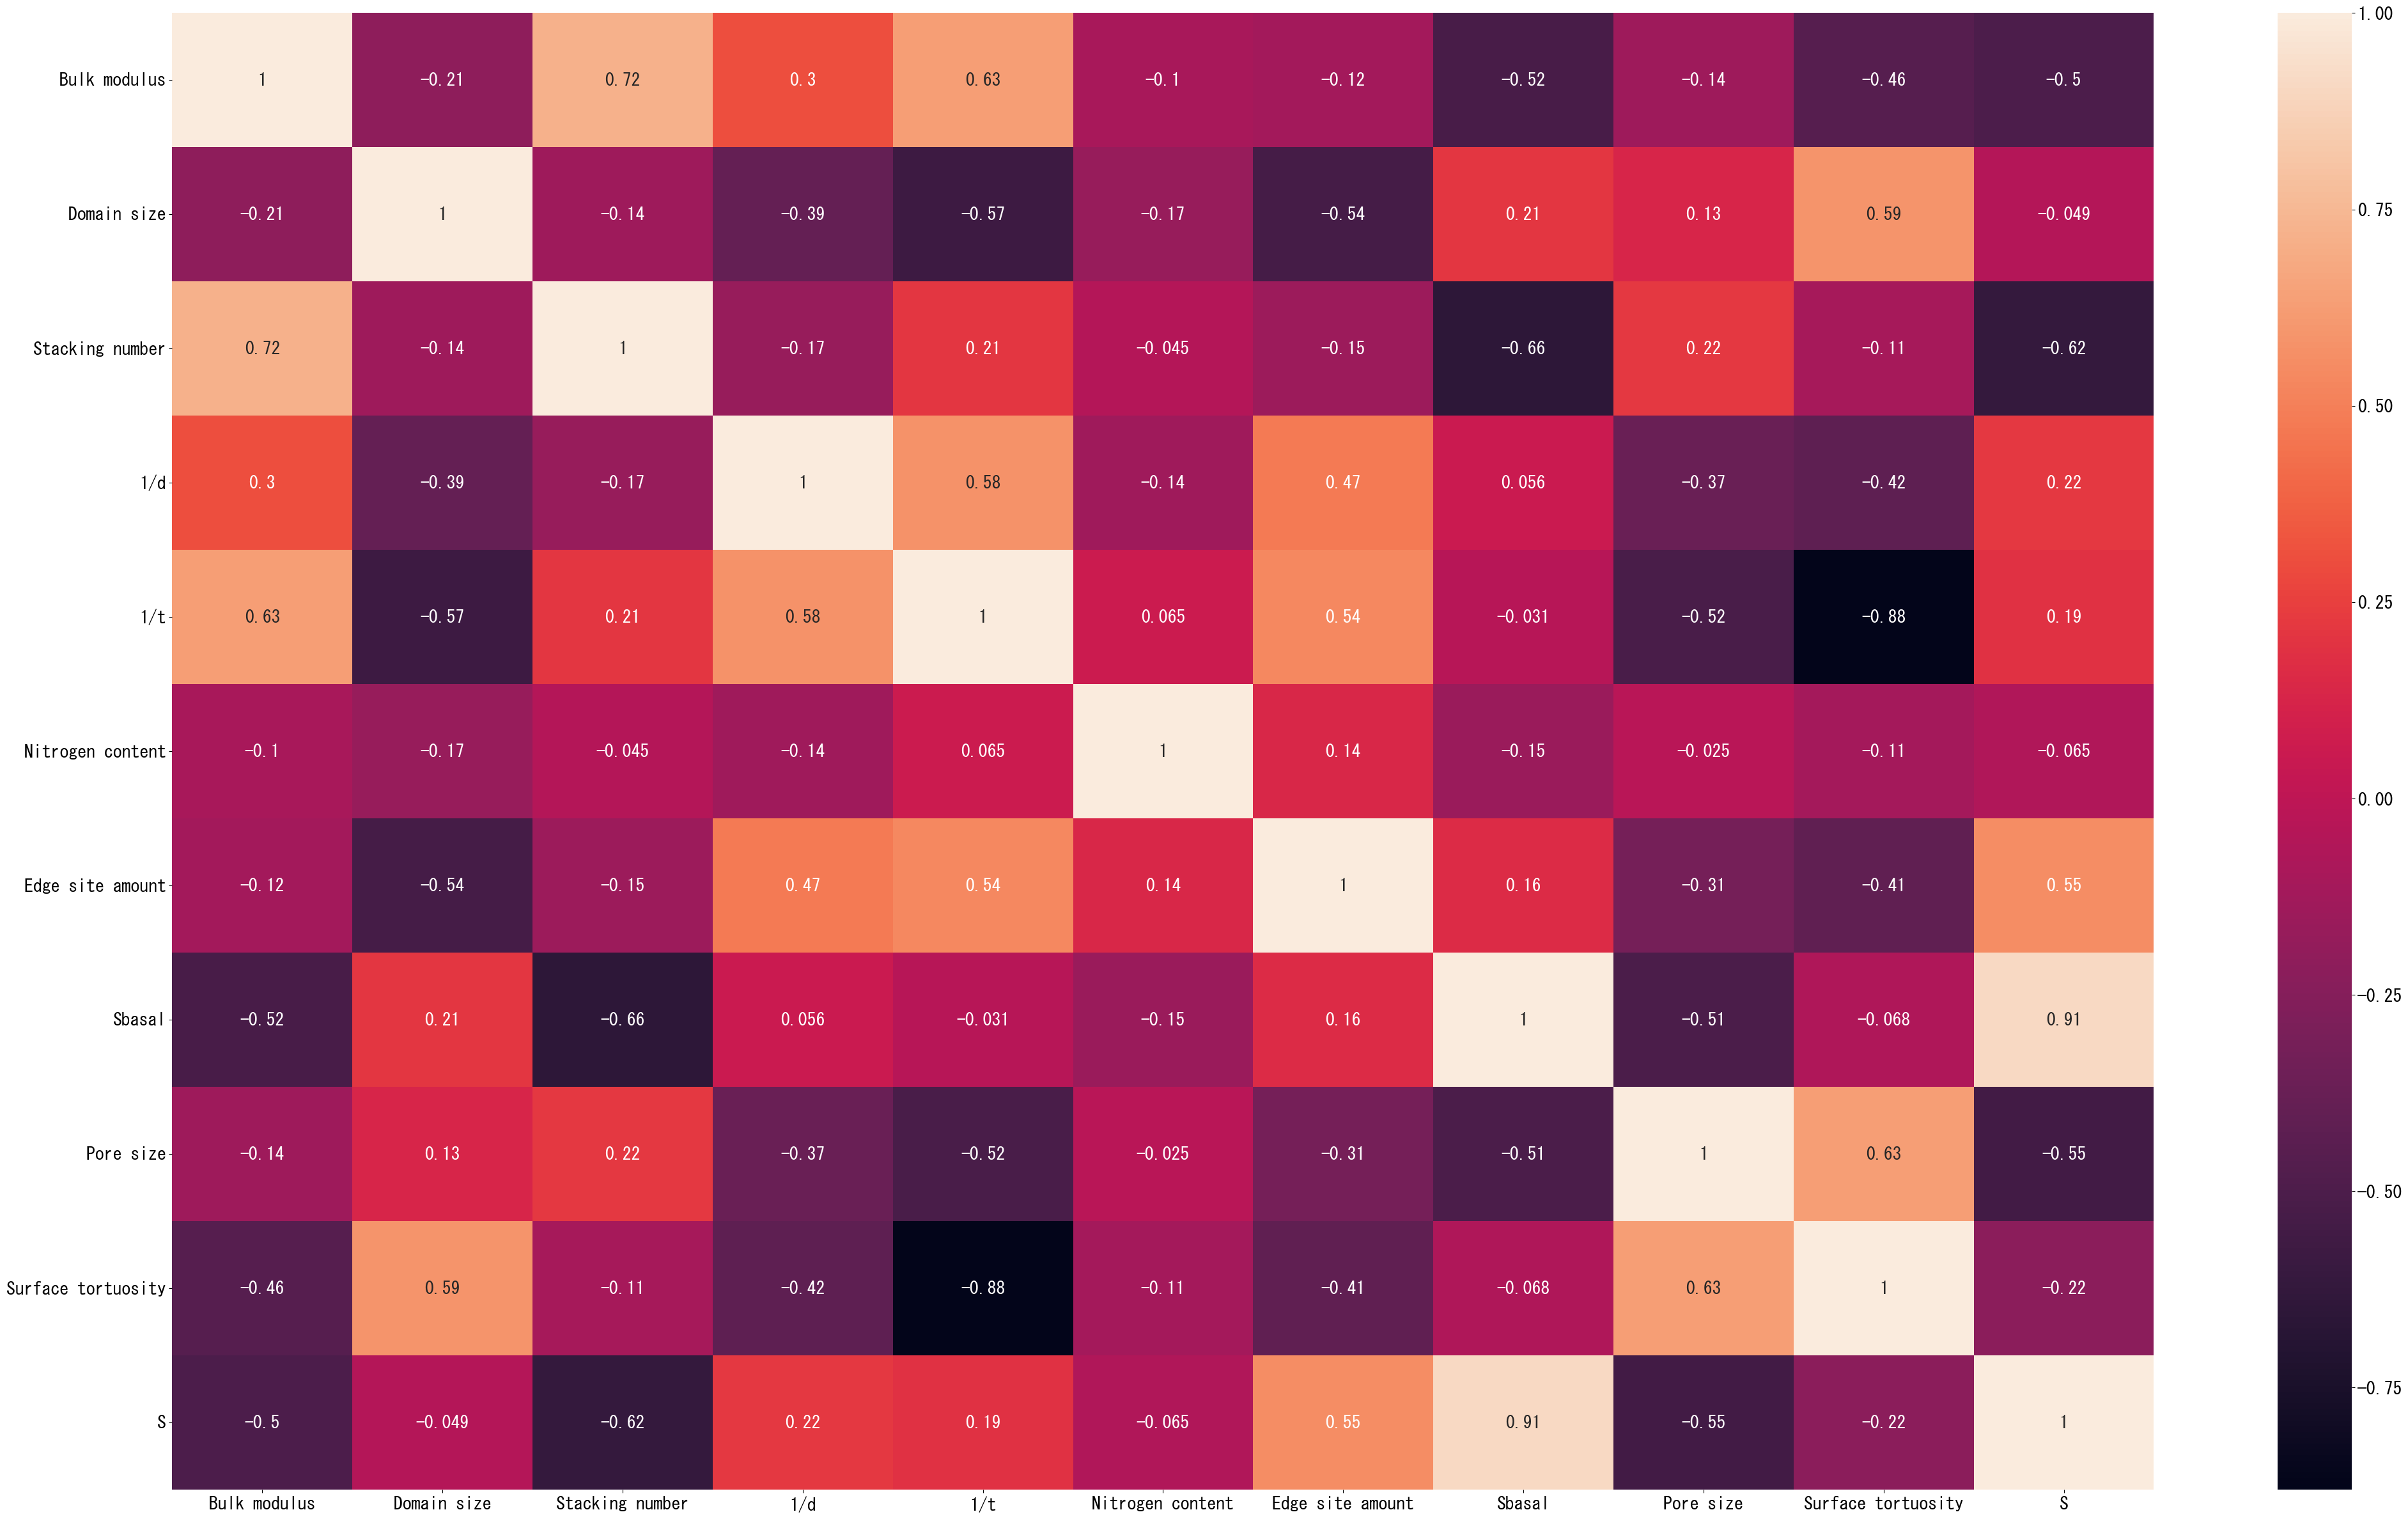

In [ ]:
if ShowCorrelation != 0:
    plt.rcParams['figure.figsize'] = (50, 30)
    plt.rcParams['font.size'] = 20
    sns.heatmap(visdata.corr(),annot=True)
    plt.savefig('{0:%Y%m%d}_correlation.png'.format(now), bbox_inches="tight")

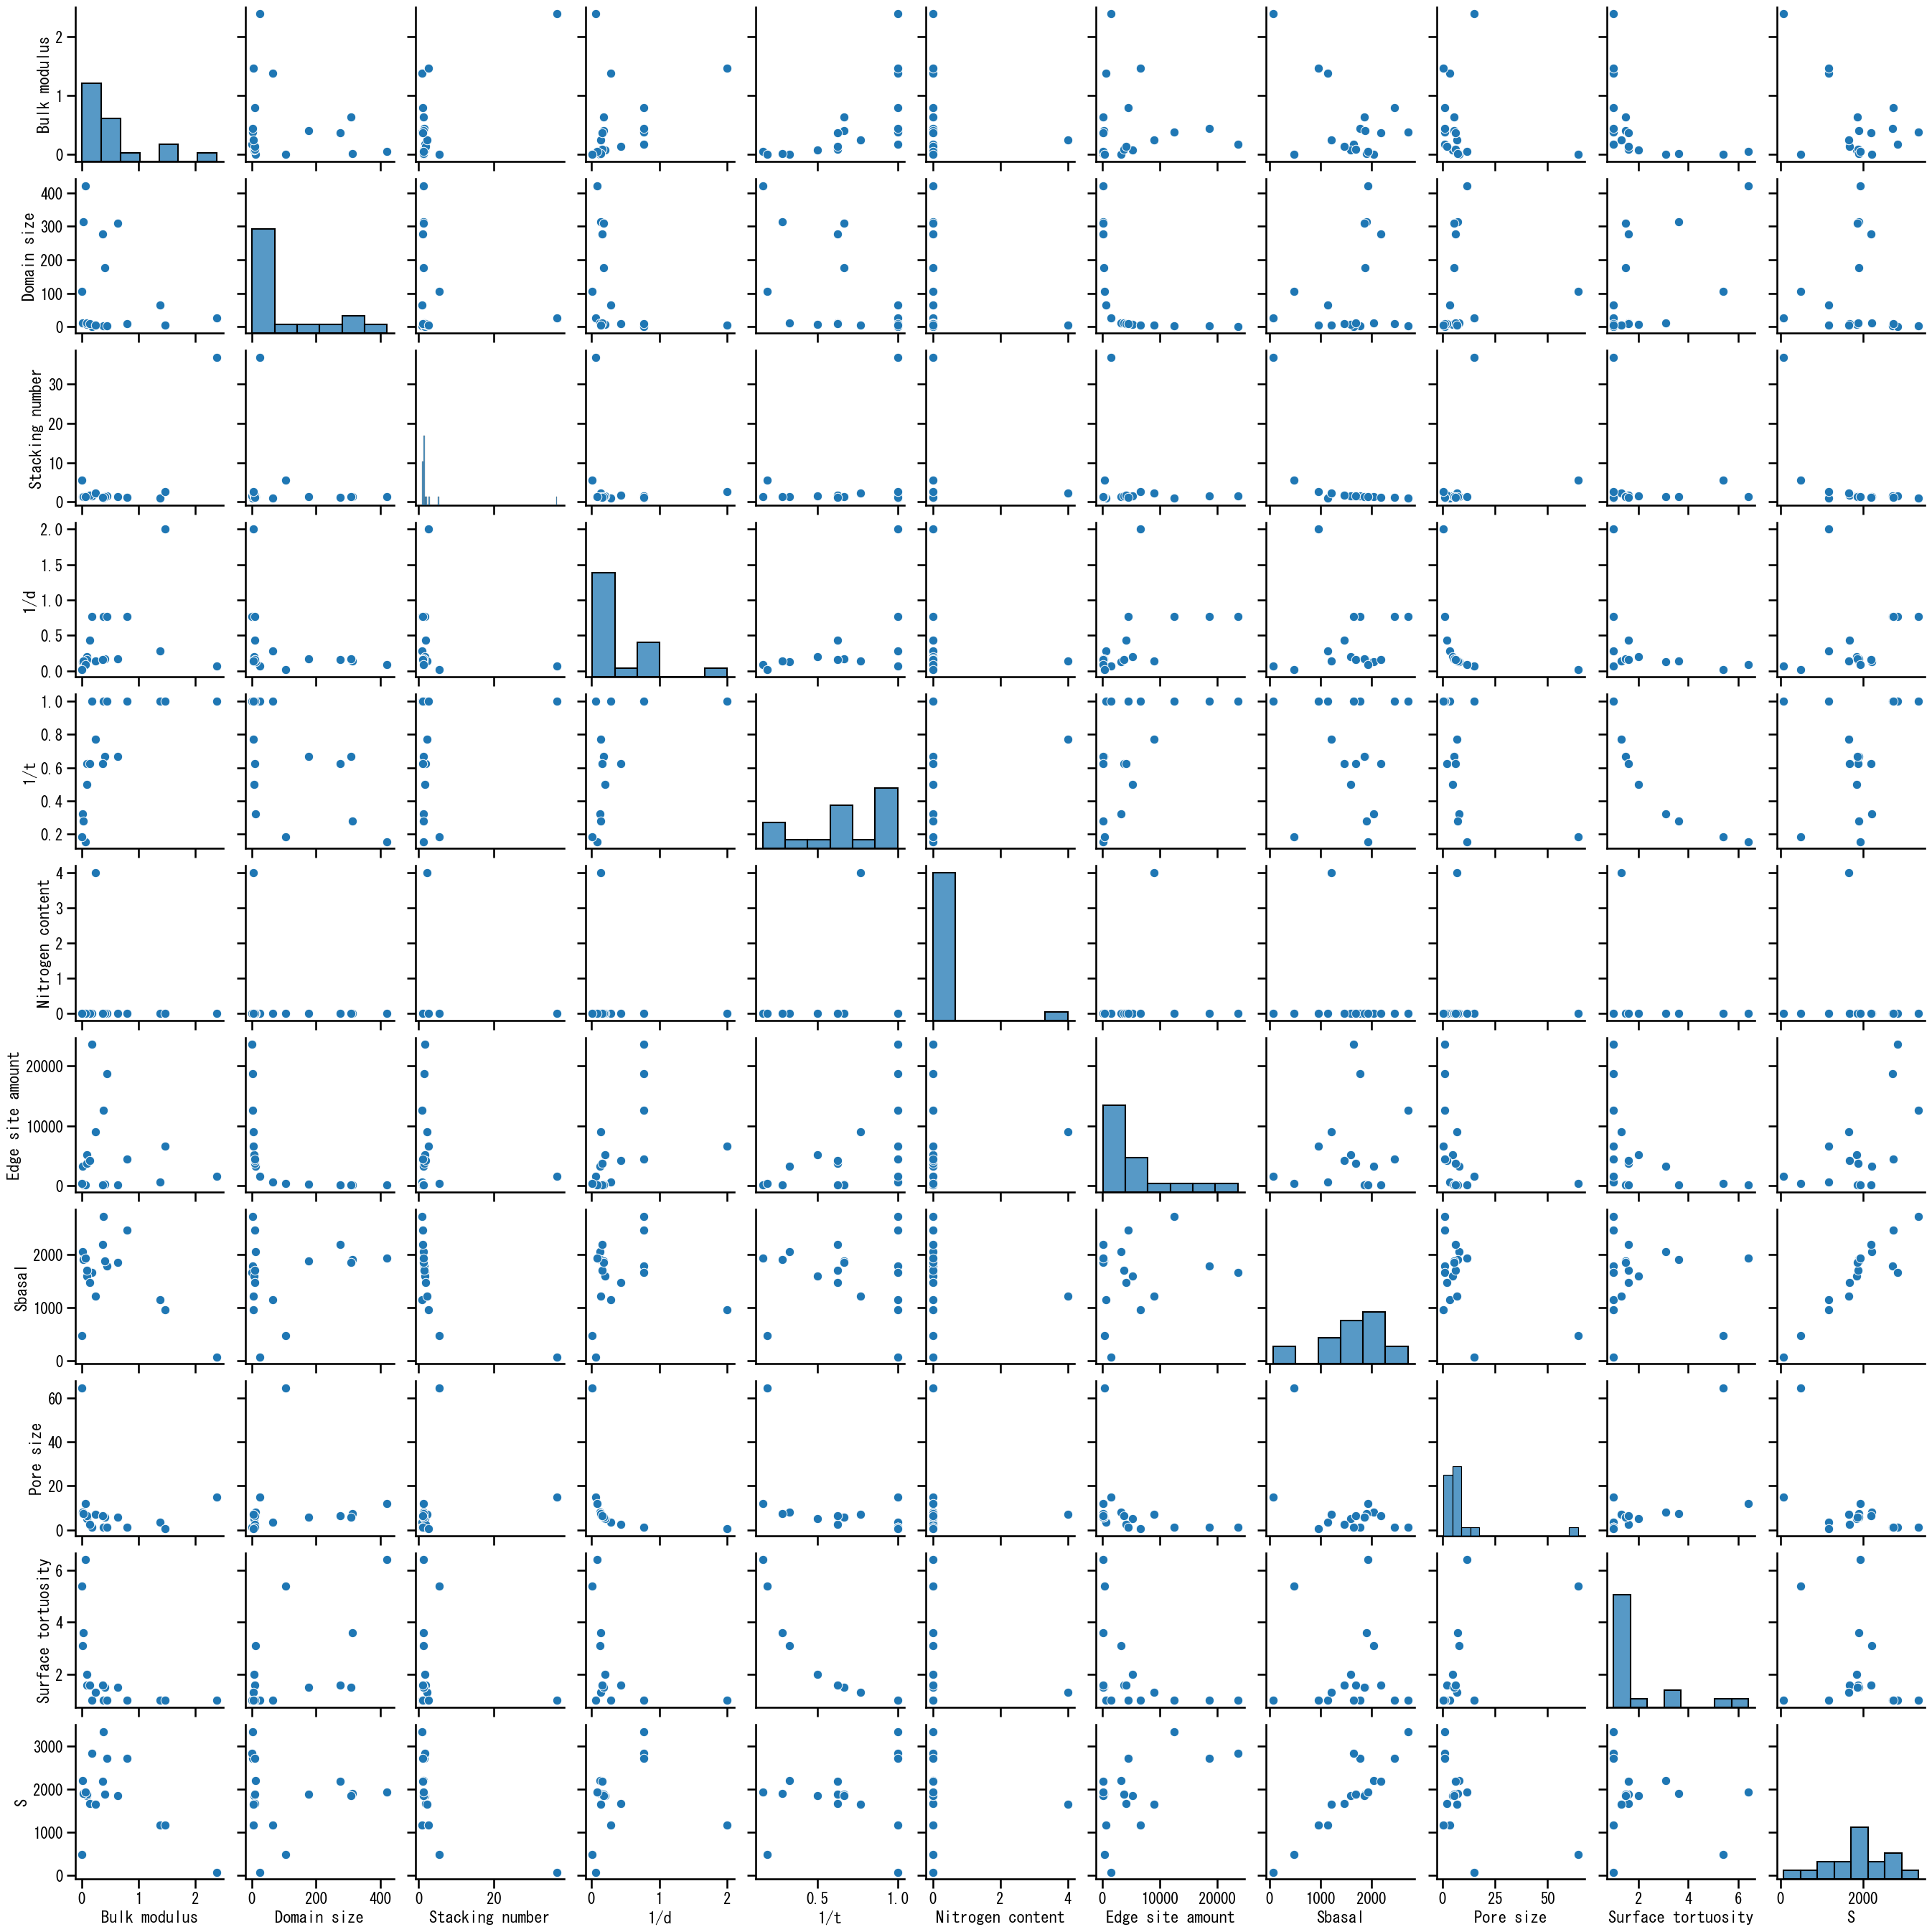

In [ ]:
if ShowPairplots != 0:
    plt.rcParams['font.size'] = 10
    plt.rcParams['figure.figsize'] = (200, 100)
    sns.set_context('talk', font_scale=0.9);
    sns.pairplot(visdata, diag_kind='hist').savefig('{0:%Y%m%d}_pairplot.png'.format(now))

### Double Cross-Validation (DCV)

In [ ]:
if DoDoubleCV != 0:
    for FoldIndNum in np.arange( 1, FoldNumberDcvout+1, 1):
        OriginalXtrain = OriginalX[FoldIndOut!=FoldIndNum,:]
        Originalytrain = Originaly[FoldIndOut!=FoldIndNum]
        OriginalXtest = OriginalX[FoldIndOut==FoldIndNum,:]
        #Find variables with zero variance
        Var0VariableDcv = variableszerovariance(OriginalXtrain)
        if len(Var0VariableDcv[0]) != 0:
            OriginalXtrain = np.delete(OriginalXtrain, Var0VariableDcv, 1)
            OriginalXtest = np.delete(OriginalXtest, Var0VariableDcv, 1)

        # Autoscale objective variable (Y) and explanatory variable (X)
        Xtrain = (OriginalXtrain - OriginalXtrain.mean(axis=0)) / OriginalXtrain.std(axis=0, ddof=1)
        ytrain = (Originalytrain - Originalytrain.mean(axis=0)) / Originalytrain.std(axis=0, ddof=1)
        Xtest = (OriginalXtest - OriginalXtrain.mean(axis=0)) / OriginalXtrain.std(axis=0, ddof=1)
        
        for RegressionMethodNumber in range(1,NumberOfRegressionMethods+1):
            print("{0} / {1}   {2}. {3} ... Start".format(FoldIndNum,FoldNumberDcvout,RegressionMethodNumber,RegressionMethodNames[RegressionMethodNumber-1]))
            if RegressionMethodNumber == 1: # 1. PLS
                pls_components = np.arange(1, min(np.linalg.matrix_rank(Xtrain) + 1, max_pls_component_number + 1), 1)
                r2cvall = list()
                for pls_component in pls_components:
                    pls_model_in_cv = PLSRegression(n_components=pls_component)
                    pls_model_in_cv.fit(Xtrain, ytrain)
                    calculated_y_in_cv = np.ndarray.flatten(pls_model_in_cv.predict(Xtrain))
                    estimated_y_in_cv = np.ndarray.flatten(model_selection.cross_val_predict(pls_model_in_cv, Xtrain, ytrain, cv=FoldNumberDcvin))
                    calculated_y_in_cv = calculated_y_in_cv * ytrain.std(ddof=1) + ytrain.mean()
                    estimated_y_in_cv = estimated_y_in_cv * ytrain.std(ddof=1) + ytrain.mean()
                    r2cvall.append(float(1 - sum((ytrain - estimated_y_in_cv) ** 2) / sum((ytrain - ytrain.mean()) ** 2)))
                # Decide the optimal number of components with the minimum r2 value
                optimal_pls_component_numberDcv = np.where(r2cvall == np.max(r2cvall))
                optimal_pls_component_numberDcv = optimal_pls_component_numberDcv[0][0] + 1
                Model = PLSRegression(n_components=optimal_pls_component_numberDcv)
            elif RegressionMethodNumber == 2: # 2. LASSO
                # Estimate objective variable (Y) with cross-validation (CV) for each lambda candidate
                # Calculate Root-Mean-Squared Error (RMSE) between actual Y and estimated Y with CV for each lambda candidate
                # Decide the optimal lambda with the minimum RMSE value
                Model = LassoCV(cv=FoldNumberDcvin, alphas=CandidatesOfLASSOLambda)
                np.random.seed()
            elif RegressionMethodNumber == 3: # 3. RR
                # Estimate objective variable (Y) with cross-validation (CV) for each lambda candidate
                # Calculate Root-Mean-Squared Error (RMSE) between actual Y and estimated Y with CV for each lambda candidate
                # Decide the optimal lambda with the minimum RMSE value
                RMSECvAll = list()
                for CandidateOfRidgeLambdas in CandidatesOfRidgeLambdas:
                    RRResult = Ridge(alpha=CandidateOfRidgeLambdas)
                    PredictedYcv = model_selection.cross_val_predict(RRResult, Xtrain, ytrain, cv=FoldNumberDcvin)*Originalytrain.std(ddof=1) + Originalytrain.mean()
                    RMSECvAll.append(math.sqrt( sum( (Originalytrain-PredictedYcv)**2 )/ Xtrain.shape[0]))
                OptimalRRLambdaDcv = CandidatesOfRidgeLambdas[np.where( RMSECvAll == np.min(RMSECvAll) )[0][0]]
                Model = Ridge(alpha=OptimalRRLambdaDcv)
            elif RegressionMethodNumber == 4: # 4. EN
                # Estimate objective variable (Y) with cross-validation (CV) for each lambda candidate and eachalpha candidate
                # Calculate Root-Mean-Squared Error (RMSE) between actual Y and estimated Y with CV for each lambda candidate and eachalpha candidate
                # Decide the optimal lambda with the minimum RMSE value
                Model = ElasticNetCV(cv=FoldNumberDcvin, l1_ratio=CandidatesOfENAlpha, alphas=CandidatesOfENLambda)
            elif RegressionMethodNumber == 5: # 5. LSVR
                # Object function
                def objective_LSVR_DCV(trial):
                    param = {
                        'C' : trial.suggest_loguniform('C',1e0, 1e2),
                        'epsilon' : trial.suggest_loguniform('epsilon',1e-1, 1e1)
                    }
                    # LSVR
                    model_lsvr_dcv = svm.SVR(kernel='linear', **param)
                    # Prediction
                    estimated_y_in_dcv = model_selection.cross_val_predict(model_lsvr_dcv, Xtrain, ytrain, cv=FoldNumberDcvin)
                    estimated_y_in_dcv = estimated_y_in_dcv * Originalytrain.std() + Originalytrain.mean()
                    r2 = metrics.r2_score(Originalytrain, estimated_y_in_dcv)
                    return r2
                  # optuna
                study_lsvr_dcv = optuna.create_study(direction='maximize')
                study_lsvr_dcv.optimize(objective_LSVR_DCV, n_trials=trials_number)
                Model = svm.SVR(kernel='linear',**study_lsvr_dcv.best_params)
            # Object function
            elif RegressionMethodNumber == 6: # 6. BR
                def objective_BR_DCV(trial):
                    param = {
                        'alpha_1' : trial.suggest_loguniform('alpha_1',1e-8,1e-5),
                        'alpha_2' : trial.suggest_loguniform('alpha_2',1e-8,1e-5),
                        'lambda_1' : trial.suggest_loguniform('lambda_1',1e-8,1e-5),
                        'lambda_2' : trial.suggest_loguniform('lambda_2',1e-8,1e-5)
                    }
                    # BR
                    model_br_dcv = linear_model.BayesianRidge(**param)
                    # Prediction
                    estimated_y_in_dcv = model_selection.cross_val_predict(model_br_dcv, Xtrain, ytrain, cv=FoldNumberDcvin)
                    estimated_y_in_dcv = estimated_y_in_dcv * Originalytrain.std() + Originalytrain.mean()
                    r2 = metrics.r2_score(Originalytrain, estimated_y_in_dcv)
                    return r2
                study_br_dcv = optuna.create_study(direction='maximize')
                study_br_dcv.optimize(objective_BR_DCV, n_trials=trials_number)
                Model = linear_model.BayesianRidge(**study_br_dcv.best_params)
            elif RegressionMethodNumber == 7: # 7. NLSVR
            # Object function
                def objective_NLSVR_DCV(trial):
                    param = {
                        'C' : trial.suggest_loguniform('C', 1e0, 1e2),
                        'epsilon' : trial.suggest_loguniform('epsilon', 1e-1, 1e1)
                    }
                    # LSVR
                    model_nlsvr_dcv = SVR(kernel='rbf', **param, gamma='auto')
                    # Prediction
                    estimated_y_in_dcv = model_selection.cross_val_predict(model_nlsvr_dcv, Xtrain, ytrain, cv=FoldNumberDcvin)
                    estimated_y_in_dcv = estimated_y_in_dcv * Originalytrain.std() + Originalytrain.mean()
                    r2 = metrics.r2_score(Originalytrain, estimated_y_in_dcv)
                    return r2           
                # optuna
                study_nlsvr_dcv = optuna.create_study(direction='maximize')
                study_nlsvr_dcv.optimize(objective_NLSVR_DCV, n_trials=trials_number)
                Model = svm.SVR(kernel='rbf',**study_nlsvr_dcv.best_params, gamma='auto')
            elif RegressionMethodNumber == 8: # 8. KR
                # Object function
                def objective_KR_DCV(trial):
                    param = {
                        'alpha' : trial.suggest_loguniform('alpha', 1e-3, 1e0),
                        'gamma' : trial.suggest_loguniform('gamma', 1e-2, 1e5)
                    }
                    # KernelRidge regression
                    model_kr_dcv = KernelRidge(kernel='rbf', **param)
                    # Prediction
                    estimated_y_in_dcv = model_selection.cross_val_predict(model_kr_dcv, Xtrain, ytrain, cv=FoldNumberDcvin)
                    estimated_y_in_dcv = estimated_y_in_dcv * Originalytrain.std() + Originalytrain.mean()
                    r2 = metrics.r2_score(Originalytrain, estimated_y_in_dcv)
                    return r2
                # optuna
                study_kr_dcv = optuna.create_study(direction='maximize')
                study_kr_dcv.optimize(objective_KR_DCV, n_trials=trials_number)
                Model = KernelRidge(kernel='rbf', **study_kr_dcv.best_params)
            elif RegressionMethodNumber == 9: # 9. RF
                # Object function
                def objective_RF_DCV(trial):
                    rf_tree = trial.suggest_int("n_estimators", 100, 1000)
                    rf_max_features = trial.suggest_categorical("max_features", ['sqrt', 'auto', 'log2'])
                    model_rf_dcv = RandomForestRegressor(n_estimators=rf_tree, max_features=rf_max_features, oob_score=True)    
                    estimated_y_in_cv_dcv = model_selection.cross_val_predict(model_rf_dcv, Xtrain, ytrain, cv=FoldNumberDcvin)
                    estimated_y_in_cv_dcv = estimated_y_in_dcv * Originalytrain.std() + Originalytrain.mean()
                    r2 = metrics.r2_score(Originalytrain, estimated_y_in_cv_dcv)
                    return r2
                # optuna
                study_rf_dcv = optuna.create_study( direction='maximize')
                study_rf_dcv.optimize(objective_RF_DCV, n_trials=trials_number)
                Model = RandomForestRegressor(**study_rf_dcv.best_params, oob_score=True)
            elif RegressionMethodNumber == 10: # 10. XGB
                # Object function
                def objective_XGB_DCV(trial):
                    param = {
                        "n_estimators" : trial.suggest_int('n_estimators', 0, 1000),
                        "max_depth" : trial.suggest_int('max_depth', 1, 20),
                        "min_child_weight" : trial.suggest_int('min_child_weight', 1, 20),
                        "subsample" : trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1),
                        "colsample_bytree" : trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)
                    }              
                    model_xgb_dcv = xgb.XGBRegressor(**param)
                    estimated_y_in_dcv = model_selection.cross_val_predict(model_xgb_dcv, Xtrain, ytrain, cv=FoldNumberDcvin)
                    estimated_y_in_dcv = estimated_y_in_dcv * Originalytrain.std() + Originalytrain.mean()
                    r2 = metrics.r2_score(Originalytrain, estimated_y_in_dcv)
                    return r2
                # optuna
                study_xgb_dcv = optuna.create_study(direction='maximize')
                study_xgb_dcv.optimize(objective_XGB_DCV, n_trials=trials_number)
                Model = xgb.XGBRegressor(**study_xgb_dcv.best_params)
            elif RegressionMethodNumber == 11: # 11. GP
                # Construct GP model
                kernel = (gp.kernels.ConstantKernel(constant_value=1, constant_value_bounds=(1e-2, 1e2))
                 * gp.kernels.RBF(length_scale=1, length_scale_bounds=(0.1, 10))
                 + gp.kernels.WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-4, 1)))
                Model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=0)
          
            Model.fit(Xtrain, ytrain)
            EstimatedYDcvAll[FoldIndOut==FoldIndNum,RegressionMethodNumber-1]= Model.predict(Xtest).T*Originalytrain.std(axis=0, ddof=1) + Originalytrain.mean(axis=0)
            print("{0} / {1}   {2}. {3} ... End".format(FoldIndNum,FoldNumberDcvout,RegressionMethodNumber,RegressionMethodNames[RegressionMethodNumber-1]))

    # Calculate statistics and show YY plots
    YMaxPredDcv = np.max( np.array([np.max(Originaly),np.max(EstimatedYDcvAll)]))
    YMinPredDcv = np.min( np.array([np.min(Originaly),np.min(EstimatedYDcvAll)]))
    StatisticsDcv = np.zeros( (2, NumberOfRegressionMethods) )
    for RegressionMethodNumber in range(0,NumberOfRegressionMethods):
        StatisticsDcv[0,RegressionMethodNumber] = calc_r2(Originaly, EstimatedYDcvAll[:,RegressionMethodNumber])
        StatisticsDcv[1,RegressionMethodNumber] = calc_mae(Originaly, EstimatedYDcvAll[:,RegressionMethodNumber])
        if ShowYYplots != 0:
            make_yyplot_est( Originaly, EstimatedYDcvAll[:,RegressionMethodNumber], YMaxPredDcv, YMinPredDcv, "Y Estimated with doucle cross-validation" + " " + RegressionMethodNames[RegressionMethodNumber], "Dcv")
    
    # Save results
    EstimatedYDcvAll = pd.DataFrame(EstimatedYDcvAll)
    EstimatedYDcvAll.index = datapd.index
    EstimatedYDcvAll.columns = RegressionMethodNames
    EstimatedYDcvAll = pd.concat( [actualy, EstimatedYDcvAll], axis=1)
    EstimatedYDcvAll.to_csv( "{0:%Y%m%d}_EstimatedYDcv.csv".format(now), encoding='cp932' )
    StatisticsDcv = pd.DataFrame(StatisticsDcv)
    StatisticsDcv.columns = RegressionMethodNames
    StatisticsDcv.index = StatisticsNames[4:]
    StatisticsDcv = pd.concat([StatisticsAll, StatisticsDcv.T], axis=1)
    StatisticsDcv = StatisticsDcv.sort_values("r2Dcv", ascending=False)
    StatisticsDcv.to_csv( "{0:%Y%m%d}_StatisticAllDcv.csv".format(now), encoding='cp932' )

In [ ]:
if DoDoubleCV != 0:
    display(StatisticsDcv)

In [ ]:
# Check time
elapsedtime = time.time() - starttime
print ("Elapsed time: {0} [sec]".format(elapsedtime))

Elapsed time: 228.29090523719788 [sec]


### SHAP

  0%|          | 0/18 [00:00<?, ?it/s]

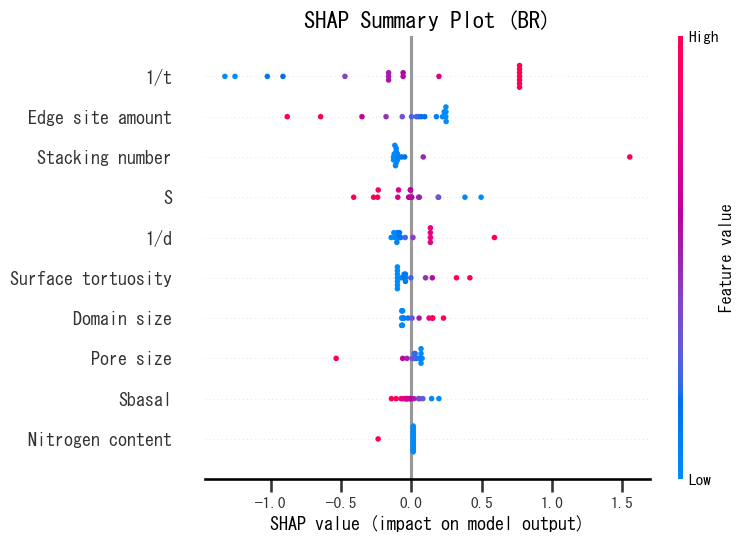

  0%|          | 0/18 [00:00<?, ?it/s]

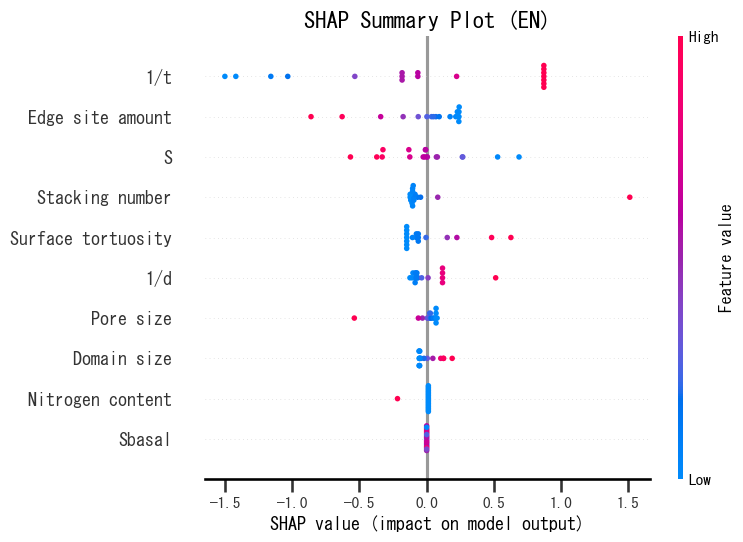

  0%|          | 0/18 [00:00<?, ?it/s]

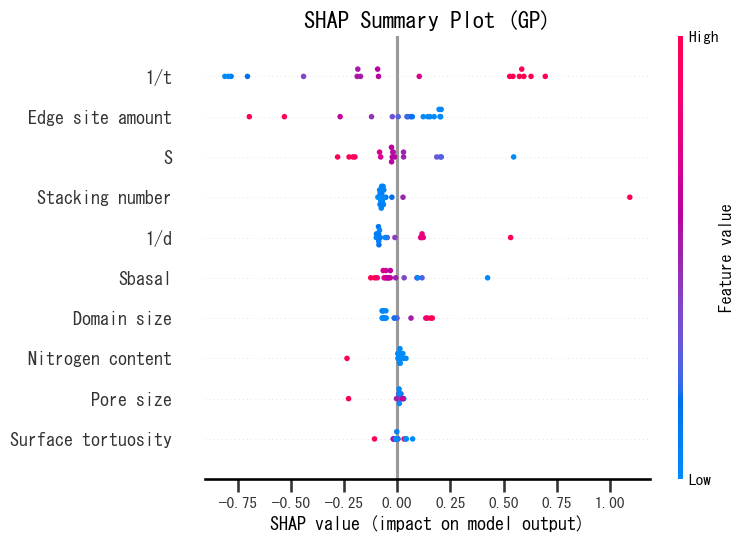

  0%|          | 0/18 [00:00<?, ?it/s]

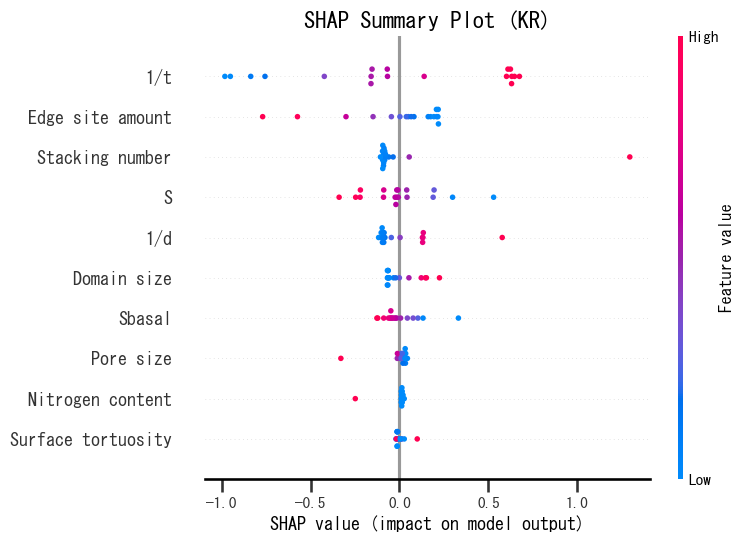

  0%|          | 0/18 [00:00<?, ?it/s]

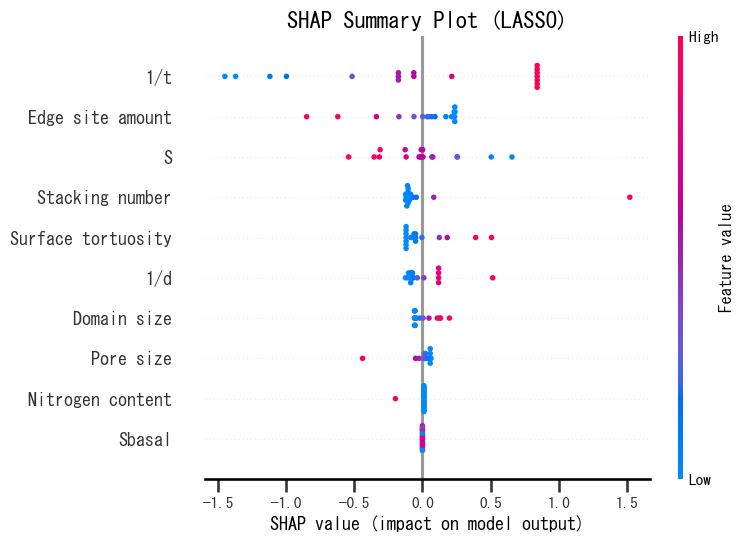

  0%|          | 0/18 [00:00<?, ?it/s]

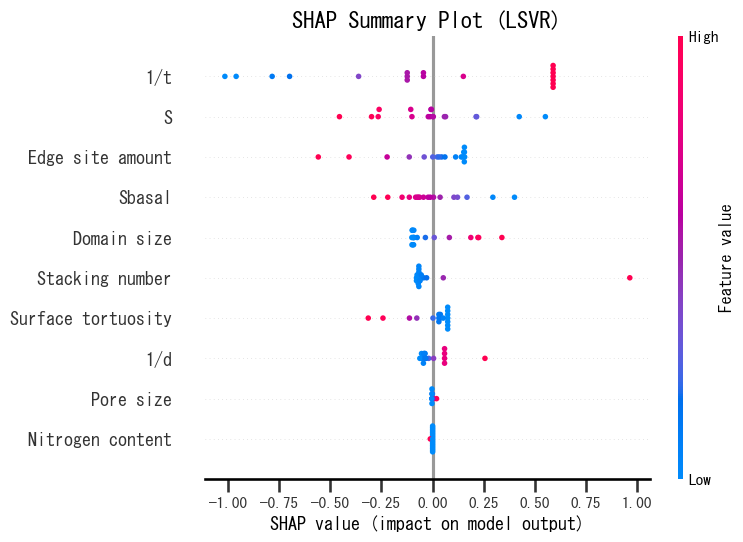

  0%|          | 0/18 [00:00<?, ?it/s]

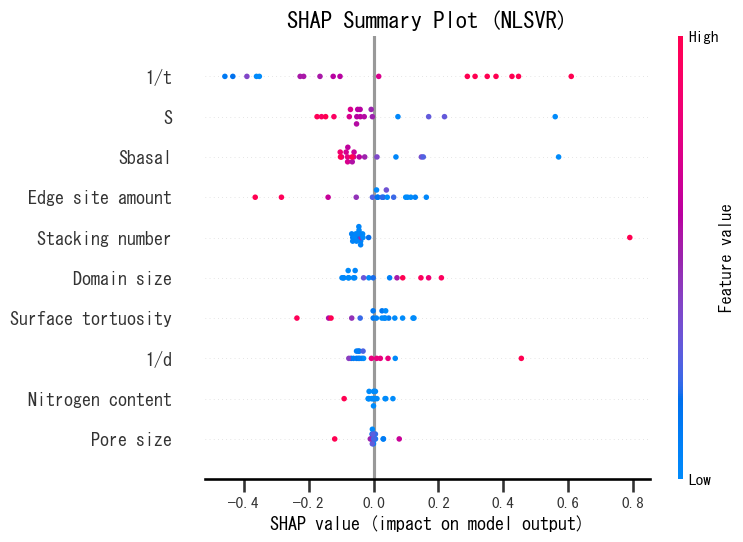

  0%|          | 0/18 [00:00<?, ?it/s]

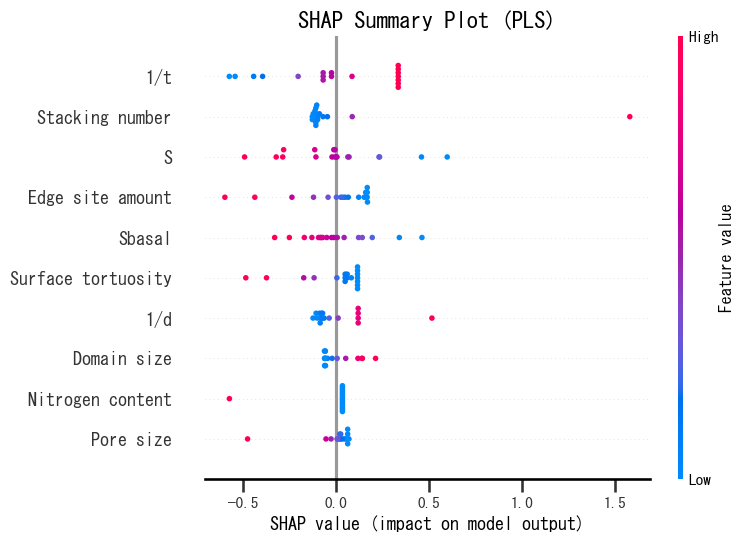

  0%|          | 0/18 [00:00<?, ?it/s]

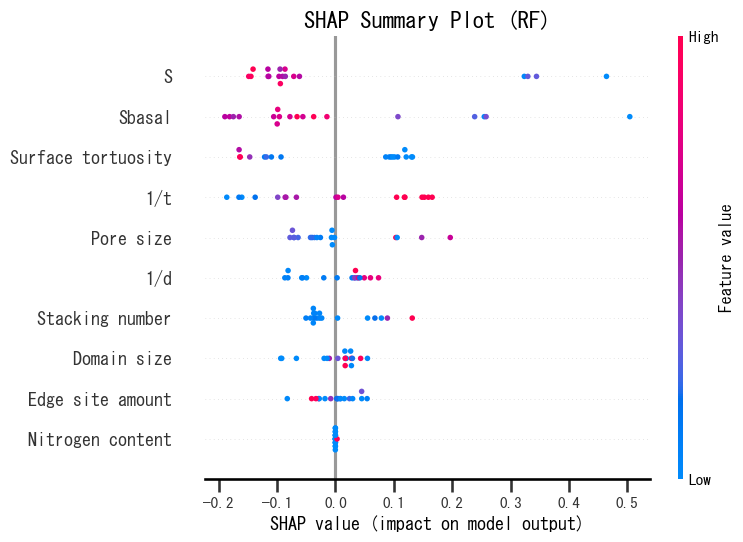

  0%|          | 0/18 [00:00<?, ?it/s]

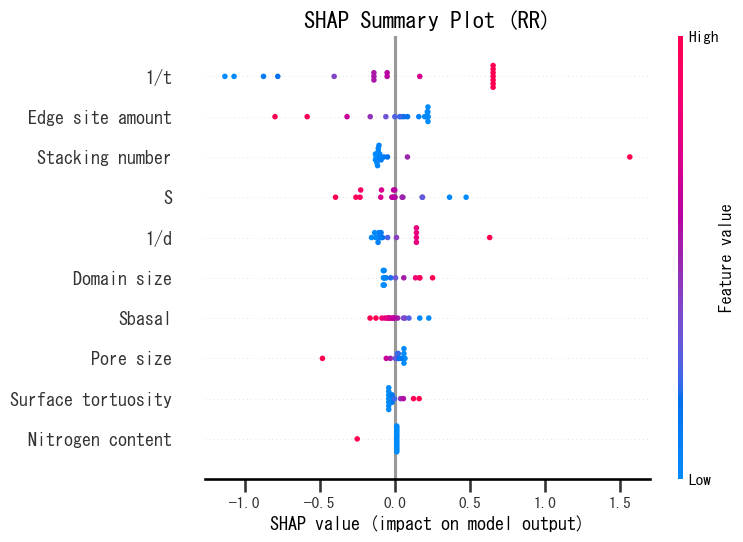

  0%|          | 0/18 [00:00<?, ?it/s]

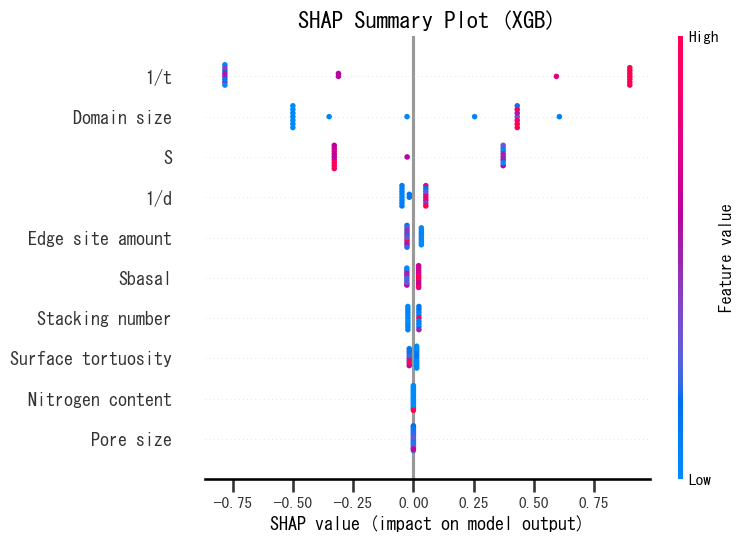

In [ ]:
if CalPermutationimportance != 0:
    path_list = glob.glob('*.pickle')
    count = 0
    models = []
    shap_values_list = []
    for i in path_list:
        file = os.path.basename(i) 
        # 拡張子を除いたファイル名取得。9文字目以降の名前を取得することでモデル名を取得
        model_name = os.path.splitext(file)[0][9:]
        models.append(model_name)
        with open(file, "rb") as f:
            model = pickle.load(f)
        if model_name in RegressionMethodNames:
            # KernelExplainerの使用
            explainer = shap.KernelExplainer(model.predict, X)
            shap_values = explainer.shap_values(X)
            shap_values_list.append(np.mean(shap_values, axis=0))
            

            # SHAP値のプロット(Beeswarmplot)
            shap.summary_plot(shap_values, X, feature_names=datapd.columns, show=False)
            plt.title(f"SHAP Summary Plot ({model_name})")
            plt.savefig('{0:%Y%m%d}_{1}_SHAP_summary.png'.format(now, model_name), bbox_inches="tight")
            plt.show()
            
            count += 1
    
    # SHAP値の平均をデータフレームに変換して保存
    shap_values_df = pd.DataFrame(shap_values_list, columns=datapd.columns, index=models)
    shap_values_df.to_csv("{0:%Y%m%d}_SHAP_values.csv".format(now), encoding='cp932')